# Predict Credit card Approval
Made by
- Yannick K. Hartington

The task here is to build a machine learning model to predict if an applicant is a 'good' or 'bad' client, were the definition of 'good' or 'bad' is not given. Thus, we need to find a way to construct the labels. Lastly, imbalance data problem is a big problem in this task, which also needs to be handle. 

# Table of content

- [Data Overview](#data-overview)
    - [Application record](#application-record)
    - [Credit record](#credit-record)
- [Initial Data Preprocessing](#Initial-Data-Preprocessing)
- [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-(EDA))
- [Feature Engineering & Preprocessing](#Feature-Engineering-&-Preprocessing)
- [Model Selection](#Model-Selection)
    - [Random Forest](#Random-Forest)
    - [XGBoost](#XGBoost)
    - [Neural Network](#Neural-Network)

### Import necessary libraries

In [1]:
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, make_scorer, recall_score, precision_score, f1_score, roc_curve, auc

### Load datasets

In [2]:
wsl_path = r'/mnt/c/Datasets/Credit Card Approval' # WSL
win_path = r'C:\Datasets\Credit card approval' # Windows

if os.path.exists(wsl_path):
    dataset_path = wsl_path 
else:
    dataset_path = win_path

application_record_path = os.path.join(dataset_path, 'application_record.csv')
credit_record_path = os.path.join(dataset_path, 'credit_record.csv')

In [3]:
application_record_df = pd.read_csv(application_record_path)
credit_record_df = pd.read_csv(credit_record_path)

## Data Overview
We will start out with inspecting the two datasets to achieve a better understanding of them. This will also enable us to get a better idea if and how we should transform some of the features.

But first a little information about the two datasets we have.
- application_record.csv contains appliers personal information
- credit_record.csv records users' behaviors of credit card
- They are connected by the ID column

Further information regarding the datasets and their features can be found [here](https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction/data). However, I find it necessary to describe a few features in the datasets. 

The application_record dataset contains two of these features:
- **DAYS_BIRTH** is the number of days since the person was born. It count backward from current day (0). Thus -1 means yesterday.
- **DAYS_EMPLOYED** is how many days the person has been employed. It count backward from current day (0) and if the number is positive, it means the person is currently unemployed.

The credit_record dataset do also contains two of these:
- **MONTHS_BALANCE** is the month of the extracted data is the starting point, backwards, 0 is the current month, -1 is the previous month, and so on.
- **STATUS** contains one of the following categories:
    - 0: 1-29 days past due 
    - 1: 30-59 days past due 
    - 2: 60-89 days overdue 
    - 3: 90-119 days overdue 
    - 4: 120-149 days overdue 
    - 5: Overdue or bad debts, write-offs for more than 150 days 
    - C: paid off that month 
    - X: No loan for the month

Now lets inspect the two datasets and see if we have to transform any of the features.

### Application record


In [4]:
application_record_df

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0
438555,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0


In [5]:
application_record_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

By looking at some rows and the summary of the dataset, it was revealed that we have a few things we need to handle:
- **ID** should be converted to strings since the IDs represent the client number, which is categorical and have no numerical value.
- The binary encoding features are not constructed the same way since some contains "Y" for yes and "N" for no and others use 1 for yes and 0 for no. We would like the latter. Thus, the features we need to transform is:
    - **FLAG_OWN_CAR**
    - **FLAG_OWN_REALTY**
- **OCCUPATION_TYPE** contains alot of missing values, which we have to look further into. 
- **DAYS_BIRTH** should be converted to something more relatable like the persons age in years.

These things will be handled in the *Data Preprocessing* section.

### Credit record

In [6]:
credit_record_df

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
...,...,...,...
1048570,5150487,-25,C
1048571,5150487,-26,C
1048572,5150487,-27,C
1048573,5150487,-28,C


In [7]:
credit_record_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


Also for this dataset should we convert the **ID** to strings.

## Initial Data Preprocessing
In this section we'll do some basic cleaning of the data by removing duplicates, correct data types, handle missing values. Furthermore, we'll do some basic feature engineering to make features values more relatable.

### Application record

#### ID

In [8]:
# Convert ID to strings
application_record_df['ID'] = application_record_df['ID'].astype(str)

Next we check if the ID column is unique 

In [9]:
application_record_df['ID'].is_unique

False

Lets have a look on the rows, where the **ID** occurs more than once

In [10]:
dublicates = application_record_df.duplicated(subset=['ID'], keep=False)
application_record_df[dublicates].sort_values(by='ID')

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
426818,7022197,M,Y,Y,3,135000.0,Working,Secondary / secondary special,Married,House / apartment,-11945,-735,1,0,0,1,Laborers,5.0
425023,7022197,F,N,Y,0,450000.0,Commercial associate,Higher education,Separated,House / apartment,-19813,-1799,1,0,0,1,NaN,1.0
431545,7022327,F,N,Y,0,135000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-14771,-5298,1,0,0,0,High skill tech staff,1.0
431911,7022327,M,Y,Y,0,256500.0,Commercial associate,Higher education,Married,House / apartment,-21503,-1674,1,0,0,1,Core staff,2.0
425486,7023108,M,Y,Y,1,67500.0,Working,Secondary / secondary special,Married,House / apartment,-15156,-1696,1,1,0,0,Core staff,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426563,7836711,F,N,Y,2,292500.0,Working,Higher education,Married,House / apartment,-13747,-4386,1,0,1,0,Accountants,4.0
421464,7836971,M,Y,N,1,157500.0,Working,Secondary / secondary special,Married,House / apartment,-13771,-5520,1,0,0,0,NaN,3.0
428620,7836971,F,N,Y,0,103500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-13383,-2798,1,0,1,0,Sales staff,2.0
422068,7838075,M,N,Y,0,337500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-18198,-1275,1,0,0,1,Drivers,2.0


It does not look like the rows are duplicates and we can not tell which are correct, so we are going to remove these from the dataset.

In [11]:
application_record_df = application_record_df[~dublicates]
application_record_df['ID'].is_unique # Check that the ID column is now unique 

True

In [12]:
# Make the ID as the index
application_record_df = application_record_df.set_index('ID')

#### FLAG_OWN_CAR & FLAG_OWN_REALTY

In [13]:
application_record_df['FLAG_OWN_CAR']

ID
5008804    Y
5008805    Y
5008806    Y
5008808    N
5008809    N
          ..
6840104    N
6840222    N
6841878    N
6842765    N
6842885    N
Name: FLAG_OWN_CAR, Length: 438463, dtype: object

In [14]:
application_record_df['FLAG_OWN_CAR'].replace({'Y': 1, 'N': 0}, inplace=True)

In [15]:
# Replace 'Y' with 1 and 'N' with 0 
application_record_df['FLAG_OWN_CAR'] = application_record_df['FLAG_OWN_CAR'].replace({'Y': 1, 'N': 0})
application_record_df['FLAG_OWN_REALTY'] = application_record_df['FLAG_OWN_REALTY'].replace({'Y': 1, 'N': 0})

#### Missing values
Lets get a better view of **OCCUPATION_TYPE**, which was the only feature with missing values

In [16]:
# Count of different values including NaN
application_record_df['OCCUPATION_TYPE'].value_counts(dropna=False)

OCCUPATION_TYPE
NaN                      134177
Laborers                  78225
Core staff                42993
Sales staff               41092
Managers                  35477
Drivers                   26085
High skill tech staff     17283
Accountants               15980
Medicine staff            13518
Cooking staff              8074
Security staff             7993
Cleaning staff             5843
Private service staff      3455
Low-skill Laborers         2140
Secretaries                2044
Waiters/barmen staff       1665
Realty agents              1041
HR staff                    774
IT staff                    604
Name: count, dtype: int64

In [17]:
# Percentage of different values including NaN
application_record_df['OCCUPATION_TYPE'].value_counts(normalize=True, dropna=False) * 100

OCCUPATION_TYPE
NaN                      30.601670
Laborers                 17.840730
Core staff                9.805388
Sales staff               9.371828
Managers                  8.091219
Drivers                   5.949191
High skill tech staff     3.941724
Accountants               3.644549
Medicine staff            3.083042
Cooking staff             1.841432
Security staff            1.822959
Cleaning staff            1.332610
Private service staff     0.787980
Low-skill Laborers        0.488069
Secretaries               0.466174
Waiters/barmen staff      0.379736
Realty agents             0.237420
HR staff                  0.176526
IT staff                  0.137754
Name: proportion, dtype: float64

So, **OCCUPATION_TYPE** is missing about 31% of its values. One way to deal with the rows that are missing data, is simply to remove them from our dataset. However, there is no clear category for unemployed. Thus, you could argue would be the missing values. I will therefore replace the missing values with the string "Unemployed", so they are also represented in the dataset. Howerver, be aware that this could be a misinterpretation of the data.

In [18]:
# Replace missing values with 'Unemployed'
application_record_df['OCCUPATION_TYPE'] = application_record_df['OCCUPATION_TYPE'].fillna('Unemployed')
application_record_df['OCCUPATION_TYPE'].value_counts(dropna=False)

OCCUPATION_TYPE
Unemployed               134177
Laborers                  78225
Core staff                42993
Sales staff               41092
Managers                  35477
Drivers                   26085
High skill tech staff     17283
Accountants               15980
Medicine staff            13518
Cooking staff              8074
Security staff             7993
Cleaning staff             5843
Private service staff      3455
Low-skill Laborers         2140
Secretaries                2044
Waiters/barmen staff       1665
Realty agents              1041
HR staff                    774
IT staff                    604
Name: count, dtype: int64

#### DAYS_BIRTH

In [19]:
# Make the days positive and divide by the number of days in a year
application_record_df['AGE'] = (-application_record_df['DAYS_BIRTH'] / 365).astype(int) 

In [20]:
application_record_df = application_record_df.drop(columns='DAYS_BIRTH')

### Credit record

#### ID

In [21]:
# Convert ID to strings
credit_record_df['ID'] = credit_record_df['ID'].astype(str)

## Response variable
We need to construct the labels of who is a 'good' and 'bad' client, however I do not have a lot of knowledge in this specific domain. Thus I have chosen to use a simple method, which just put every client that have been more than 60 days overdue, as a bad client.

In [22]:
risk_ids = credit_record_df[credit_record_df['STATUS'].isin(['2', '3', '4', '5'])]['ID'].drop_duplicates()

application_record_df['RISK'] = application_record_df.index.isin(risk_ids).astype(int)

## Exploratory Data Analysis (EDA)
Now, lets perform an EDA, which will be done to examine the dataset and summarize the main characteristics. This will among other things help us understand the data even better, detect patterns and spot anomalies. 

Lets start by looking at our newly created response variable

### Response variable

In [23]:
risk_count = application_record_df['RISK'].value_counts()
risk_count

RISK
0    437847
1       616
Name: count, dtype: int64

In [24]:
risky_ids_count = risk_count[1]
percentage_ones = (risky_ids_count / risk_count.sum()) * 100

print(f"The sum of risky IDs: {risky_ids_count}")
print(f"Percentage of risky IDs: {percentage_ones:.2f}%")

The sum of risky IDs: 616
Percentage of risky IDs: 0.14%


We can see that only 0.14% of all the clients is bad, which shows the big imbalance problem we have in this dataset. <br>Lets explore the dataset some more and look at the features.

### Application record

In [25]:
categorical_cols = application_record_df.select_dtypes(include=['object']).columns
numerical_cols = application_record_df.select_dtypes(include=[np.number]).columns

# Check for binary columns within numerical columns
binary_cols = [col for col in numerical_cols if 'FLAG' in col]

# Remove binary columns from numerical columns list
numerical_cols = [col for col in numerical_cols if col not in binary_cols and col != 'RISK']

print('Categorical columns:\n', categorical_cols)
print('')
print('Numerical columns:\n', numerical_cols)
print('')
print('Binary columns:\n', binary_cols)

Categorical columns:
 Index(['CODE_GENDER', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE'],
      dtype='object')

Numerical columns:
 ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_EMPLOYED', 'CNT_FAM_MEMBERS', 'AGE']

Binary columns:
 ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL']


#### Categorical


Counts of Categories in CODE_GENDER:
 RISK              0    1
CODE_GENDER             
F            293999  379
M            143848  237


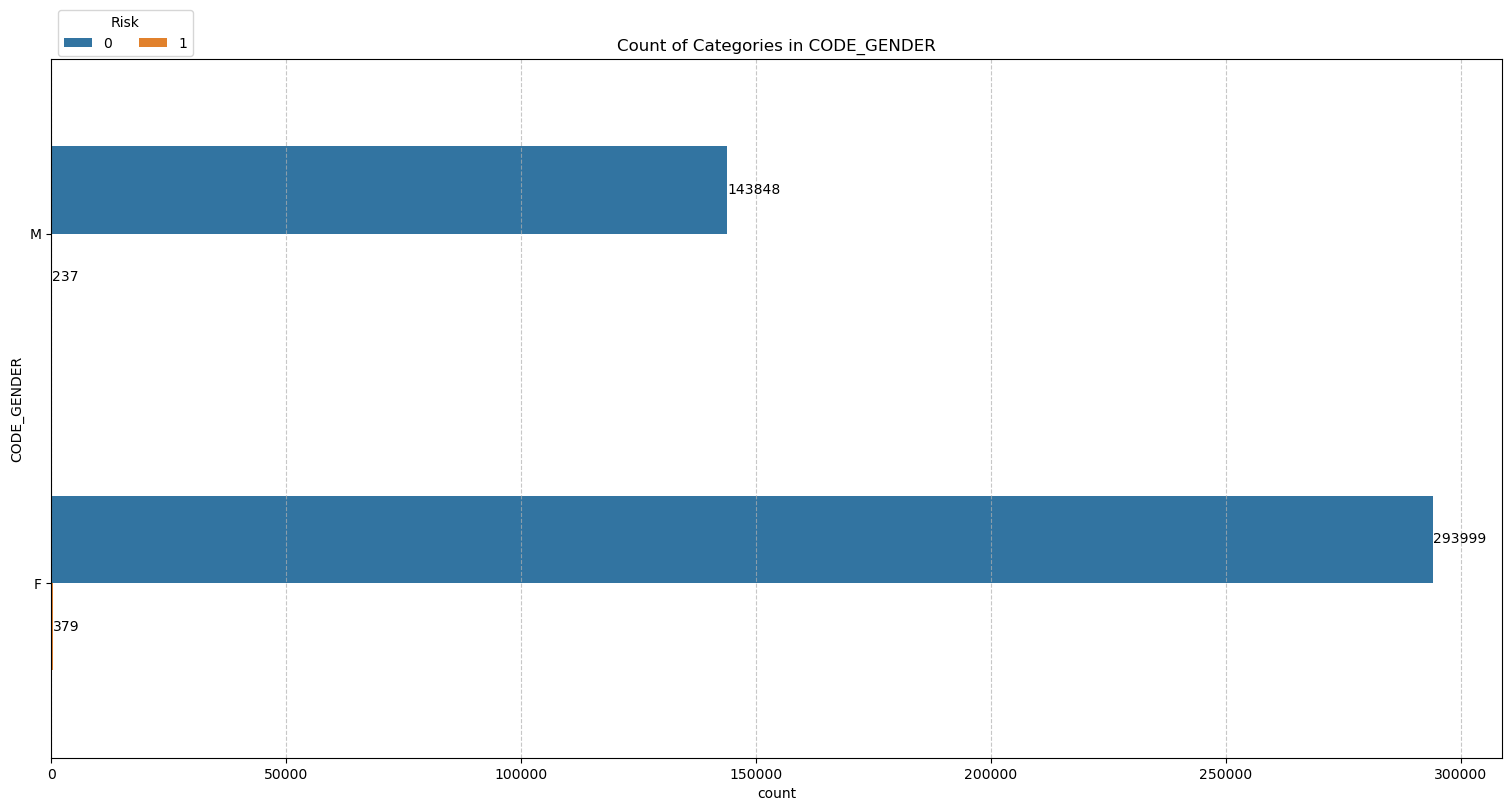


Counts of Categories in NAME_INCOME_TYPE:
 RISK                       0    1
NAME_INCOME_TYPE                 
Commercial associate  100583  143
Pensioner              75348  130
State servant          36146   37
Student                   17    0
Working               225753  306


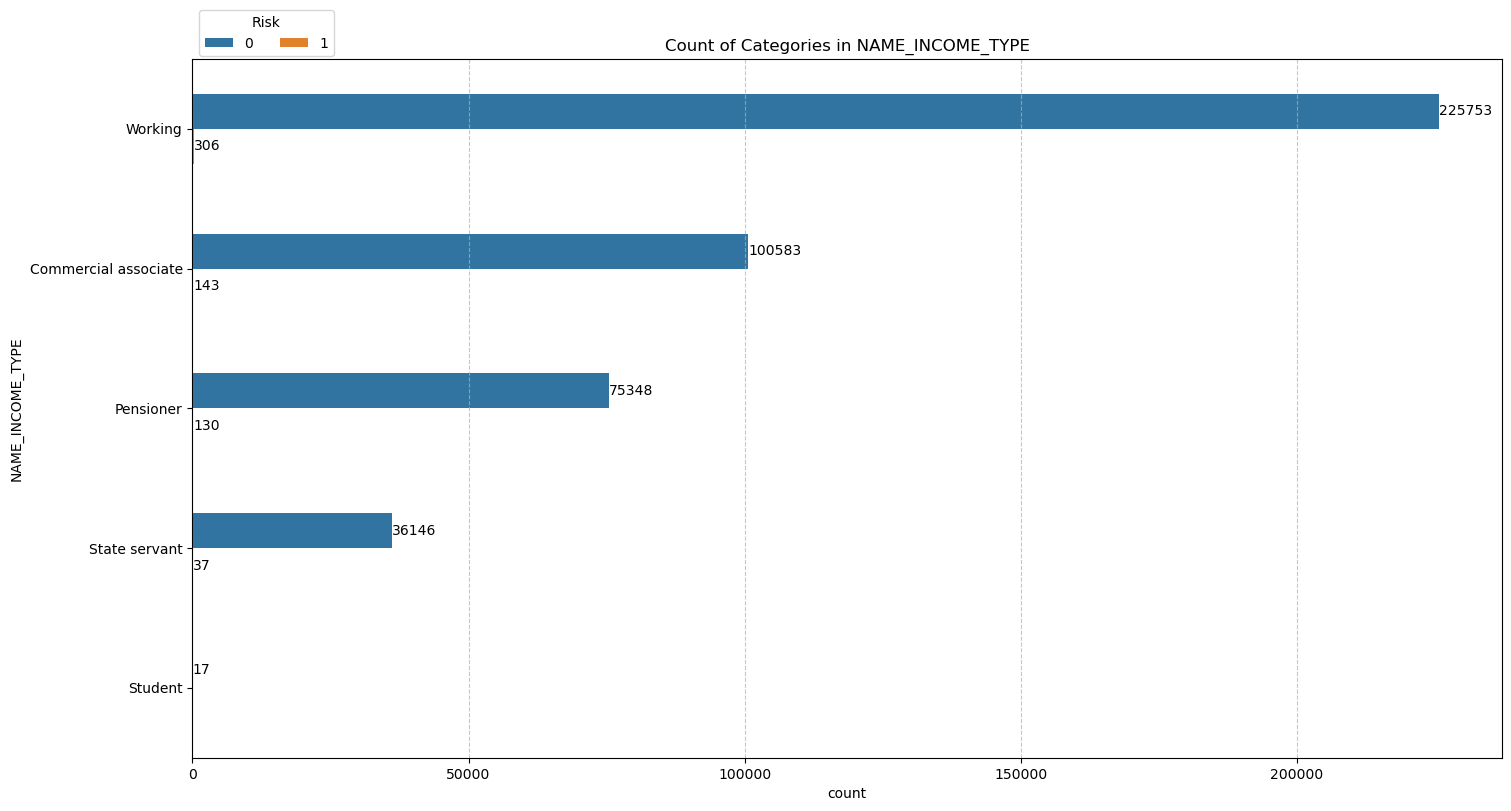


Counts of Categories in NAME_EDUCATION_TYPE:
 RISK                                0    1
NAME_EDUCATION_TYPE                       
Academic degree                   312    0
Higher education               117328  171
Incomplete higher               14812   33
Lower secondary                  4041   10
Secondary / secondary special  301354  402


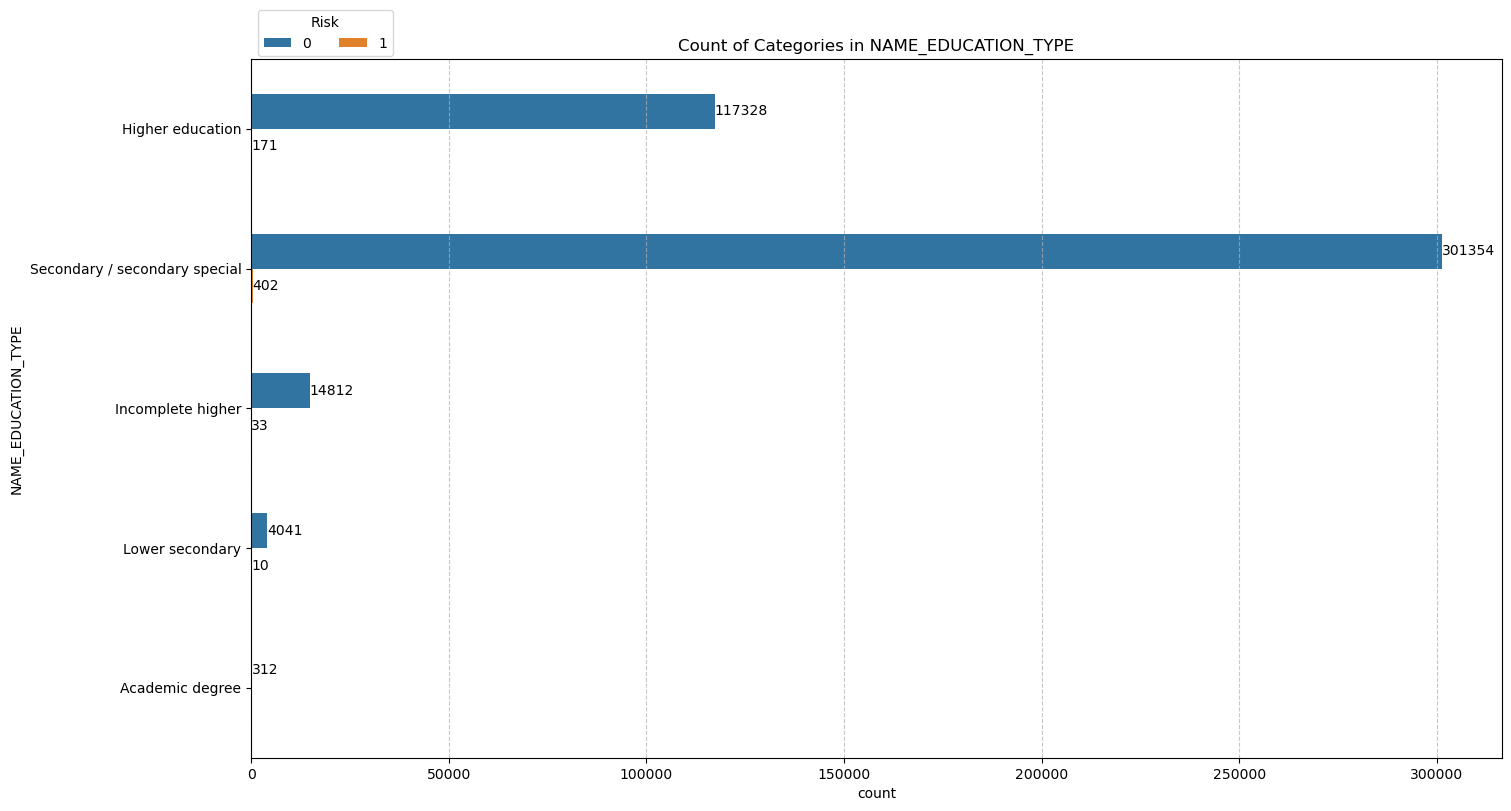


Counts of Categories in NAME_FAMILY_STATUS:
 RISK                       0    1
NAME_FAMILY_STATUS               
Civil marriage         36475   46
Married               299375  393
Separated              27218   31
Single / not married   55154  101
Widow                  19625   45


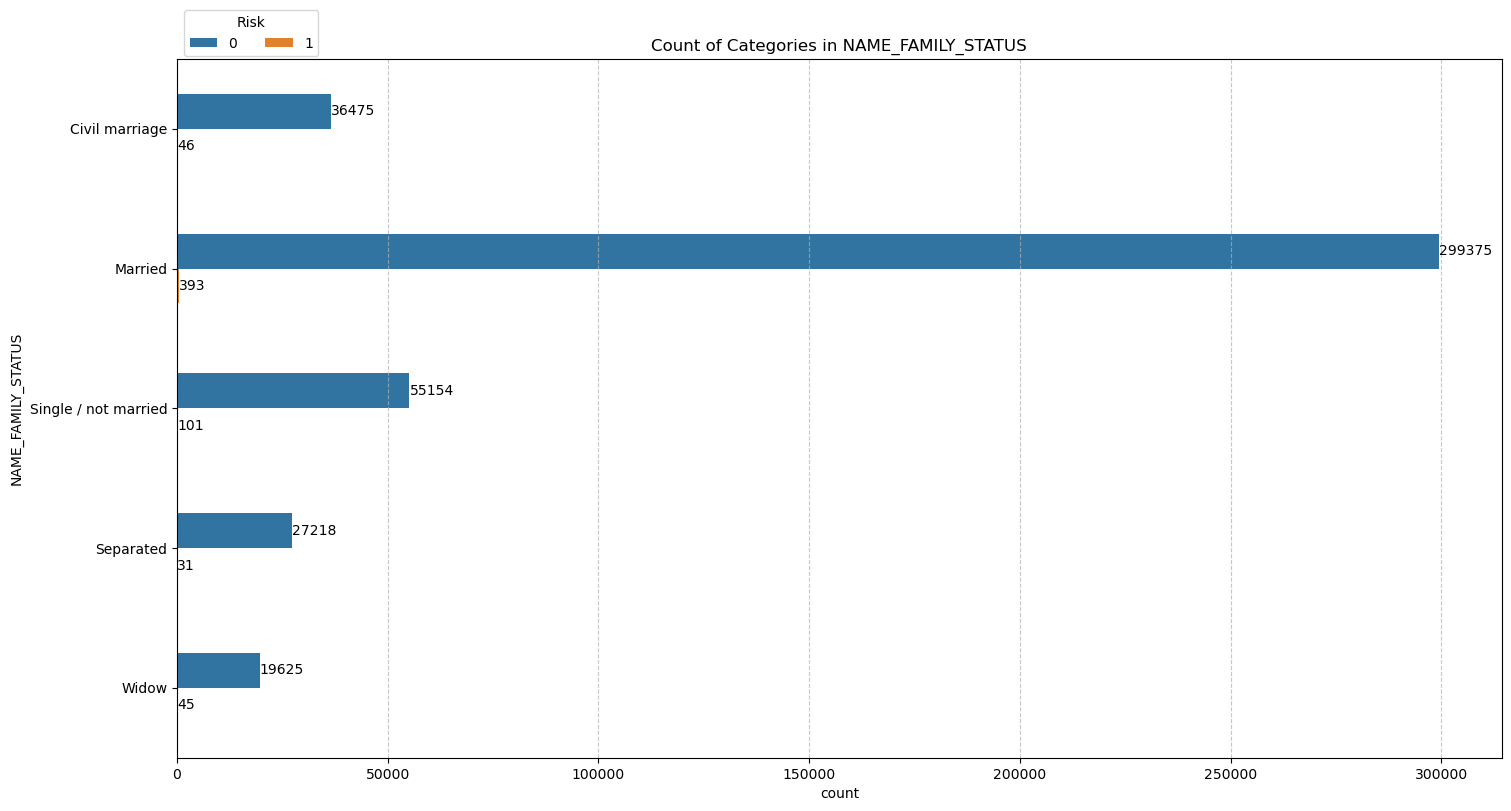


Counts of Categories in NAME_HOUSING_TYPE:
 RISK                      0    1
NAME_HOUSING_TYPE               
Co-op apartment        1536    3
House / apartment    393208  540
Municipal apartment   14181   30
Office apartment       3911    9
Rented apartment       5965    8
With parents          19046   26


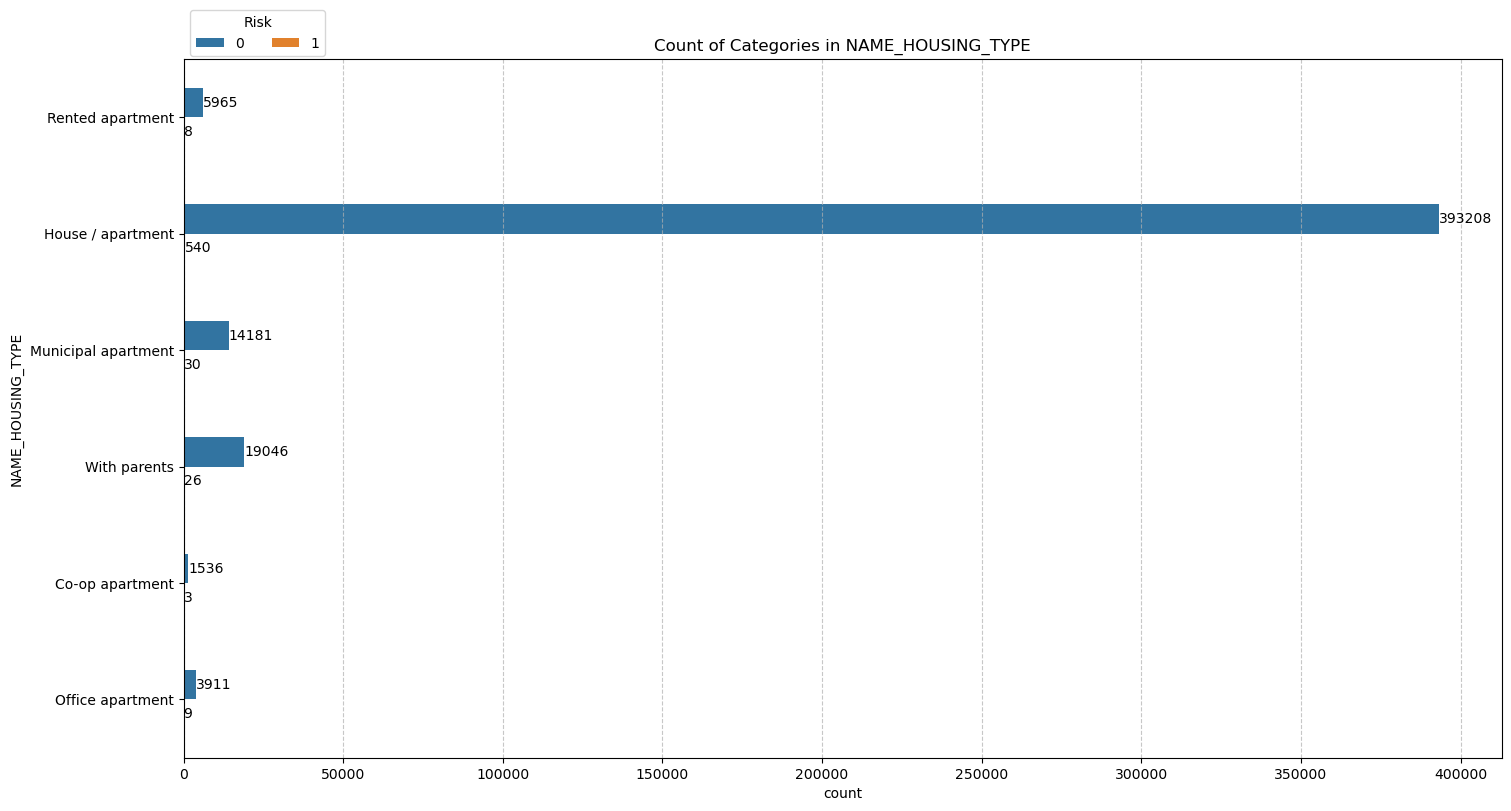


Counts of Categories in OCCUPATION_TYPE:
 RISK                        0    1
OCCUPATION_TYPE                   
Accountants             15957   23
Cleaning staff           5838    5
Cooking staff            8065    9
Core staff              42919   74
Drivers                 26036   49
HR staff                  773    1
High skill tech staff   17253   30
IT staff                  601    3
Laborers                78126   99
Low-skill Laborers       2132    8
Managers                35430   47
Medicine staff          13508   10
Private service staff    3453    2
Realty agents            1041    0
Sales staff             41047   45
Secretaries              2042    2
Security staff           7980   13
Unemployed             133983  194
Waiters/barmen staff     1663    2


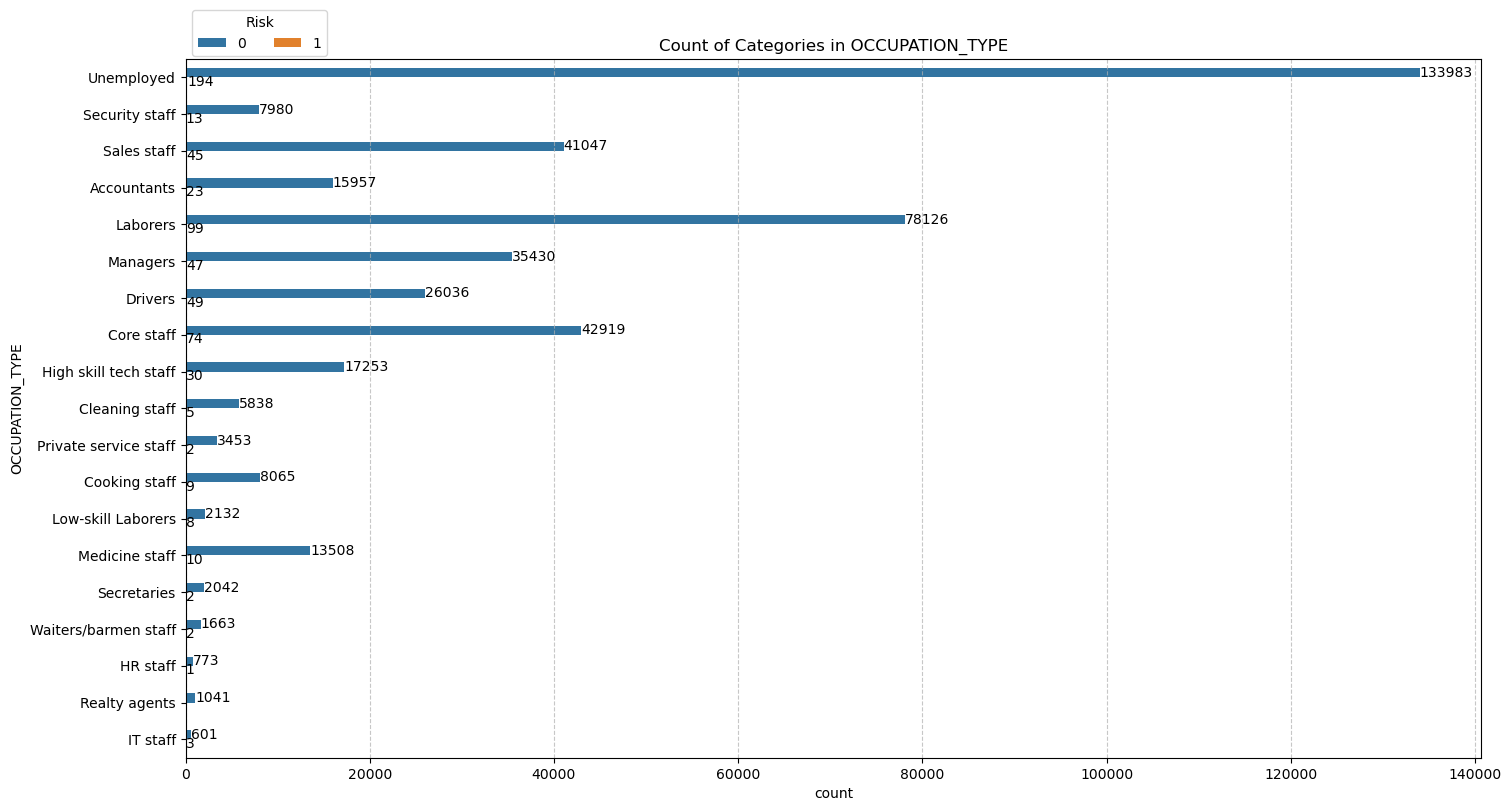

In [26]:
for i, column in enumerate(categorical_cols):
    # Group and count data by category and risk
    category_counts = application_record_df.groupby([column, 'RISK']).size().unstack(fill_value=0)

    # Display the counts DataFrame
    print(f"\nCounts of Categories in {column}:\n", category_counts)

    # Create a plot with a fixed size
    fig, ax = plt.subplots(figsize=(15, 8), constrained_layout=True)

    # Create a count plot with seaborn
    sns.countplot(data=application_record_df, y=column, hue='RISK', ax=ax, width=0.5)

    # Add bar labels to each bar
    for container in ax.containers:
        ax.bar_label(container)

    # Adjust the legend position above the left corner of the plot
    ax.legend(
        loc='upper left',
        ncol=2,
        bbox_to_anchor=(0, 1.08),  # Fine-tune the position to be just above the plot's left corner
        title='Risk'
    )

    # Add title and gridlines
    ax.set_title(f'Count of Categories in {column}')
    ax.grid(axis='x', linestyle='--', alpha=0.7)

    # Display the plot
    plt.show()

In the above plots we really get a sense of how imbalanced the dataset is. We also notice that there are no value that gives a strong indication of a risky customer. 

#### Numerical

In [27]:
risk_df_0 = application_record_df[application_record_df['RISK'] == 0][numerical_cols]
risk_df_1 = application_record_df[application_record_df['RISK'] == 1][numerical_cols]


In [28]:
print("Summary Statistics for RISK = 0:")
display(risk_df_0.describe().round(2))
print("Summary Statistics for RISK = 1:")
display(risk_df_1.describe().round(2))

Summary Statistics for RISK = 0:


,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_EMPLOYED,CNT_FAM_MEMBERS,AGE
count,437847.00,437847.00,437847.00,437847.00,437847.00
mean,0.43,187524.34,60558.00,2.19,43.33
std,0.72,110099.91,138763.66,0.90,11.47
min,0.00,26100.00,-17531.00,1.00,20.00
25%,0.00,121500.00,-3104.00,2.00,34.00
50%,0.00,161100.00,-1468.00,2.00,42.00
75%,1.00,225000.00,-371.00,3.00,53.00
max,19.00,6750000.00,365243.00,20.00,69.00


Summary Statistics for RISK = 1:


,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_EMPLOYED,CNT_FAM_MEMBERS,AGE
count,616.00,616.00,616.00,616.00,616.00
mean,0.43,185864.76,65209.68,2.16,43.13
std,0.74,97509.15,142335.75,0.93,11.69
min,0.00,36000.00,-12827.00,1.00,22.00
25%,0.00,115875.00,-2628.75,2.00,33.00
50%,0.00,162000.00,-1132.00,2.00,42.00
75%,1.00,225000.00,-242.75,3.00,52.25
max,4.00,900000.00,365243.00,6.00,67.00


When looking at these statistics we may wonder how the max for **DAYS_EMPLOYED** can be 365.243 days. Note that negative numbers of days is the number of days a customer has been employed. Thus Positive numbers is days a customer has been unemployed. Thus, somebody has been unemployed for about 1000 years. That does not sound quite right.

Lets look at some histograms and box plots to get a better idea of the distribution of the features.

In [29]:
# Function to show a histogram and a boxplot
def hist_box_plot(df, col_name):
    plt.figure(figsize=(15, 8))  # Set the figure size
    grid = plt.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.4)  # Create grid layout
    
    # Subplot for histograms
    plt.subplot(grid[0])
    sns.histplot(df[col_name], kde=True)
    plt.title(f'Distribution of {col_name}')

    # Subplot for boxplots
    plt.subplot(grid[1])
    sns.boxplot(x=col_name, data=df, hue='RISK')
    plt.title(f'Boxplot of {col_name} by RISK')
    plt.legend(title='RISK', loc='lower left', bbox_to_anchor=(-0.055, 0.6), borderaxespad=0)
    
    plt.show()

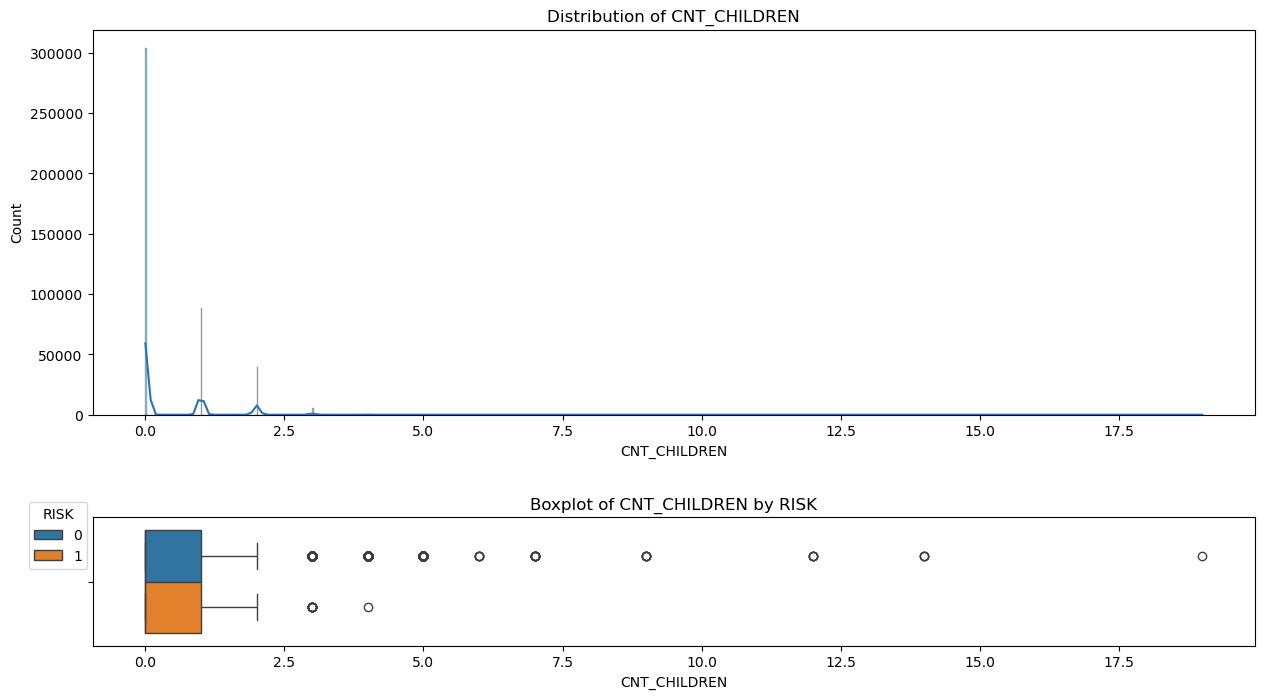

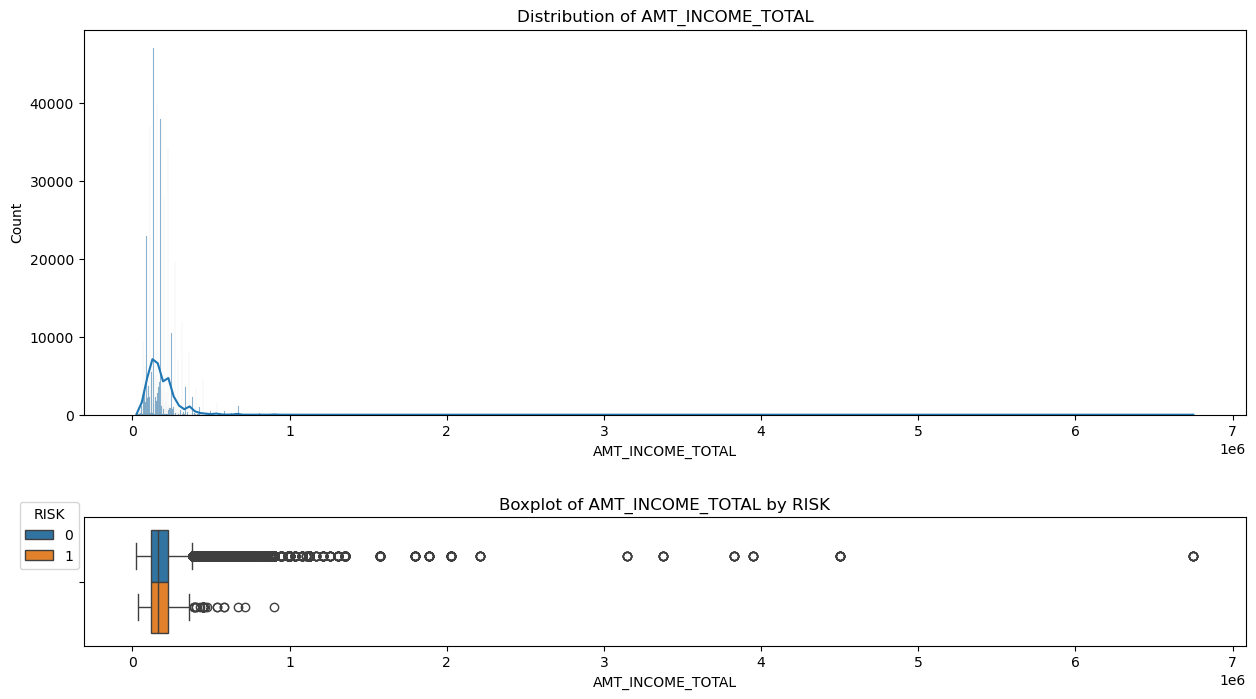

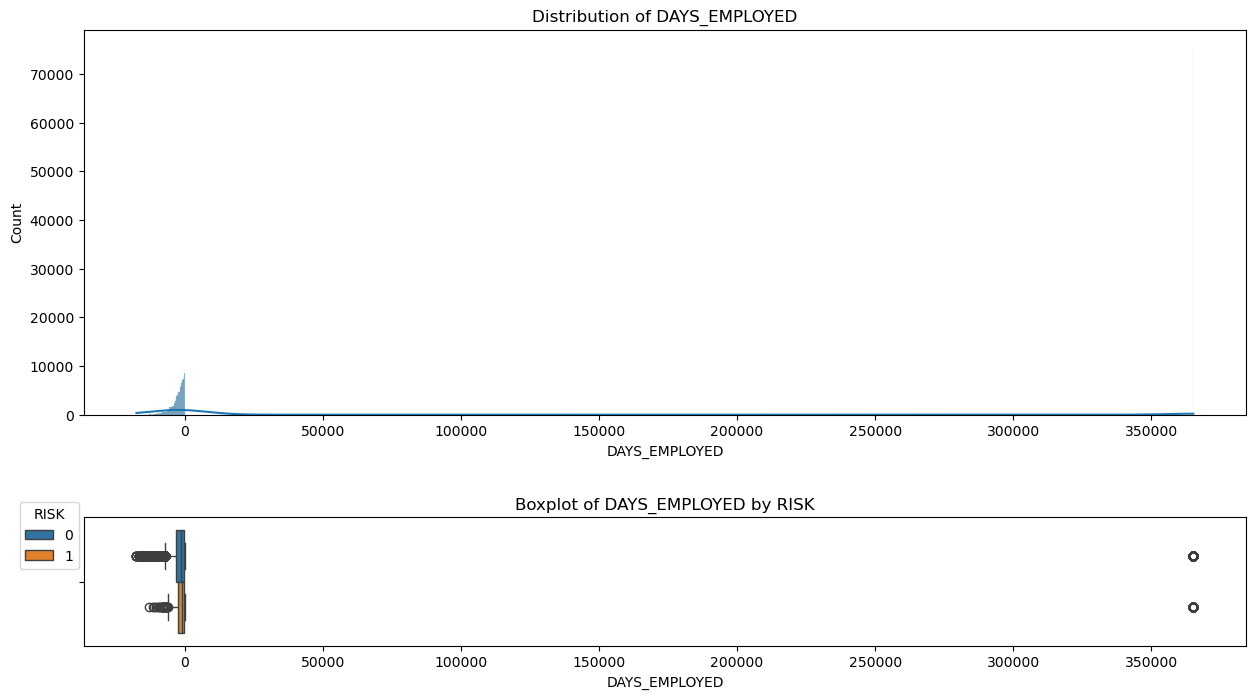

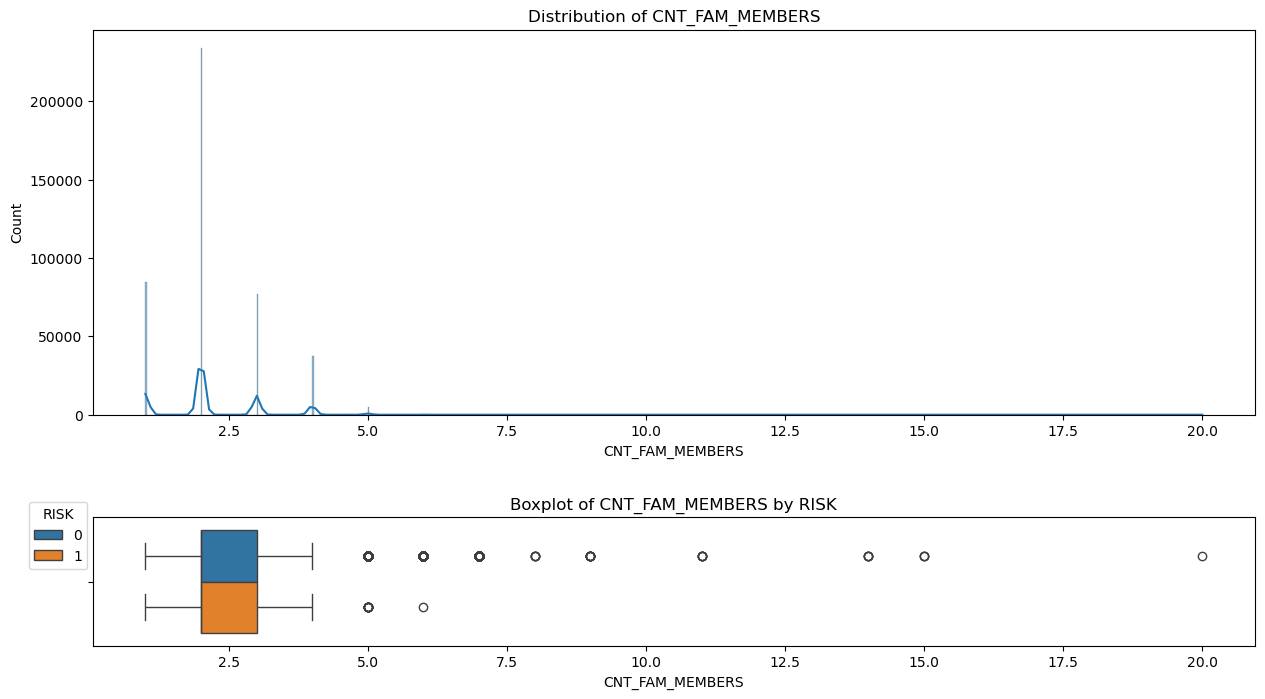

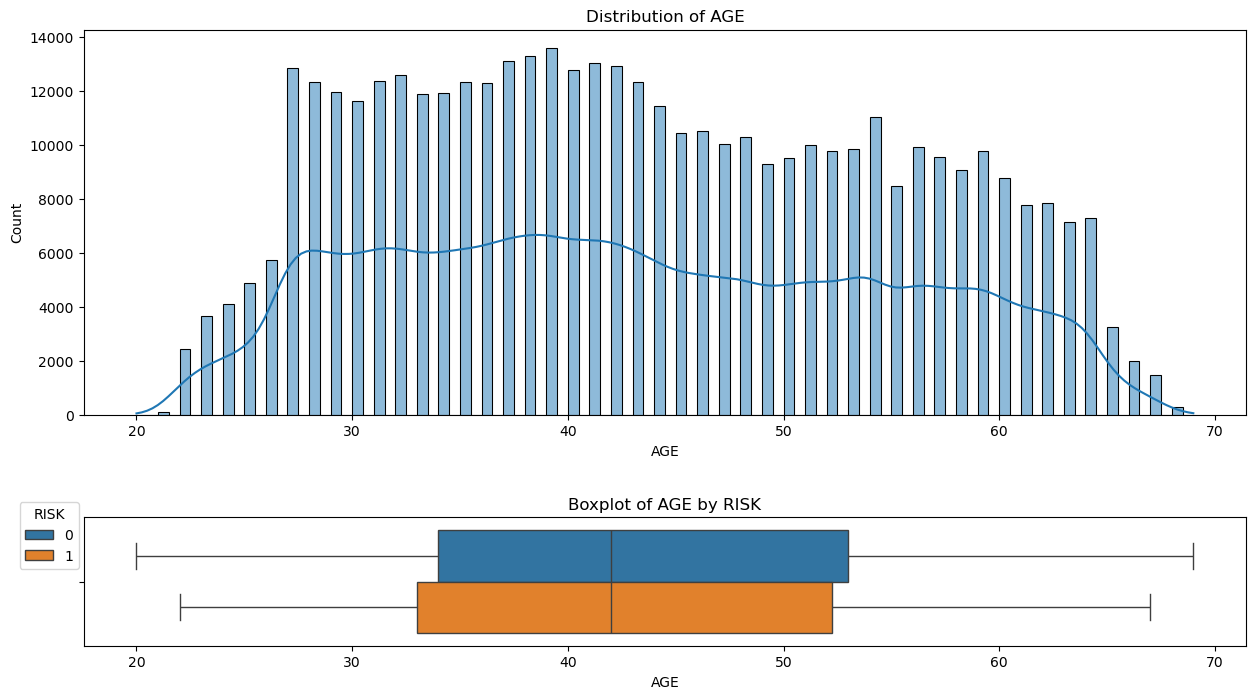

In [30]:
for col in numerical_cols:
    hist_box_plot(df=application_record_df, col_name=col)

As with the categorical variables, we do not see anything that strikes out for the risky customers. The mean and standard deviation is pretty similar for all the numerical features. However, the plots for **DAYS_EMPLOYED** does indicate that something is wrong with some of the observations. These outliers do also make it harder to get a good view of the distribution, which also applies to **AMT_INCOME_TOTAL**. 

Lets try remove those outliers and create the plots again.

In [31]:
# Create a function to identify outliers
def identify_outliers(col_name):
    # Calculate 25th percentile and the 75th percentil 
    q1 = np.percentile(application_record_df[col_name], 25)
    q3 = np.percentile(application_record_df[col_name], 75)

    # Calculate the Inner Quantile Range
    iqr = q3 - q1

    # Calculate the lower and upper limits
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr

    # Identify outliers
    outliers = application_record_df[(application_record_df[col_name] < lower_limit) | (application_record_df[col_name] > upper_limit)]

    return outliers

Number of outliers: 19100


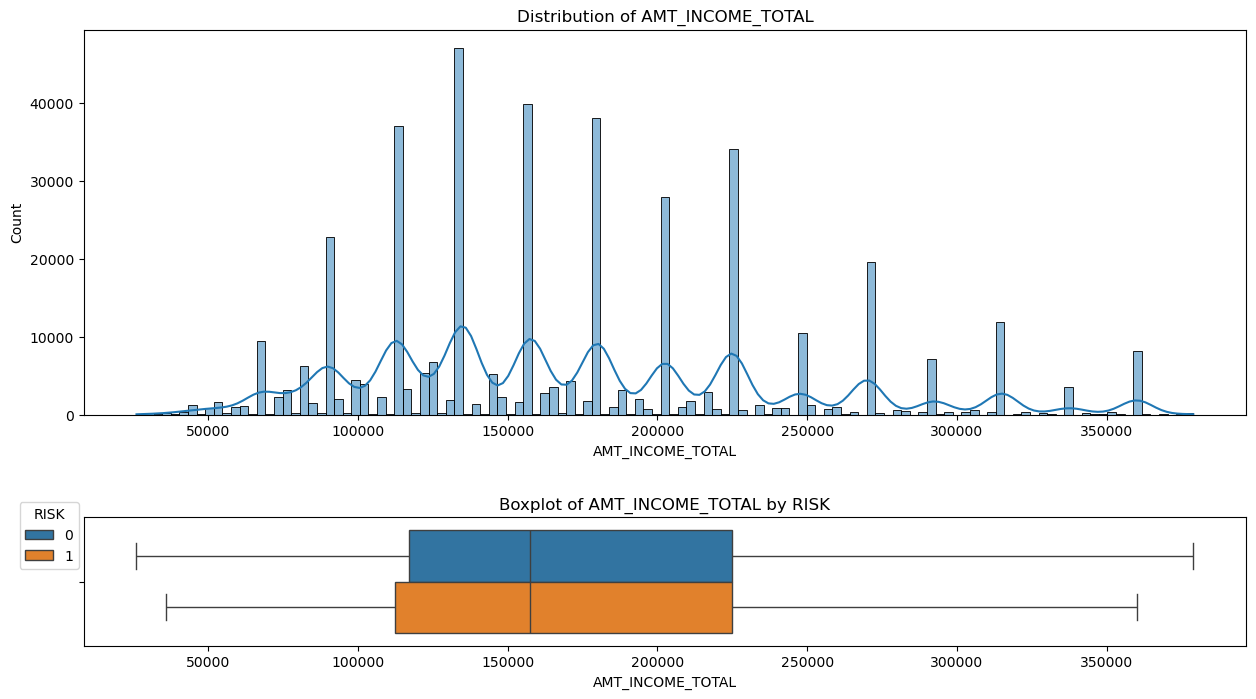

In [32]:
# Identify the outliers in AMT_INCOME_TOTAL
outliers_income = identify_outliers('AMT_INCOME_TOTAL')
print("Number of outliers:", len(outliers_income.index))

# Remove outliers 
df_income_without_outliers = application_record_df[~application_record_df['AMT_INCOME_TOTAL'].isin(outliers_income['AMT_INCOME_TOTAL'])]

# Plot again
hist_box_plot(df=df_income_without_outliers, col_name='AMT_INCOME_TOTAL')

Again there is no real difference between the two groups.

Number of outliers: 97282


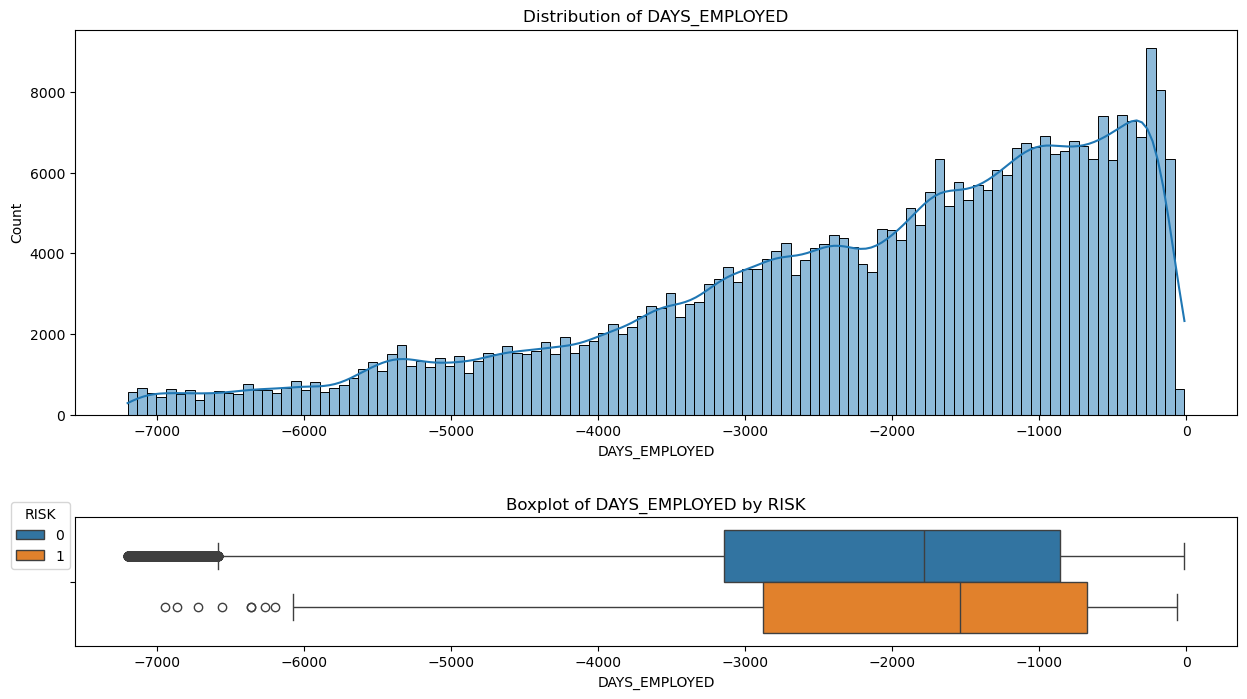

In [33]:
outliers_days_employed = identify_outliers('DAYS_EMPLOYED')
print("Number of outliers:", len(outliers_days_employed.index))

df_days_employed_without_outliers = application_record_df[~application_record_df['DAYS_EMPLOYED'].isin(outliers_days_employed['DAYS_EMPLOYED'])]

hist_box_plot(df=df_days_employed_without_outliers, col_name='DAYS_EMPLOYED')

Here we get a much better view of the distribution, which is very left-skewed. We can therefore see that it is people, who are fairly new in a job, who apply for a credit card. 

Once again there is not much difference between risky customers and good customers. However, risky customers seems to have been employed in a bit less days.

Before we move on with the EDA, we need to remove the outliers from **DAYS_EMPLOYED** since these are clearly some kind of error. 

In [34]:
# Remove outliers in DAYS_EMPLOYED from the dataset
application_record_df = application_record_df[~application_record_df['DAYS_EMPLOYED'].isin(outliers_days_employed['DAYS_EMPLOYED'])]

Next we'll construct a correlation matrix to better understand the linear relationship between the numeric features as well as a scatter plot to visualize each relationship.

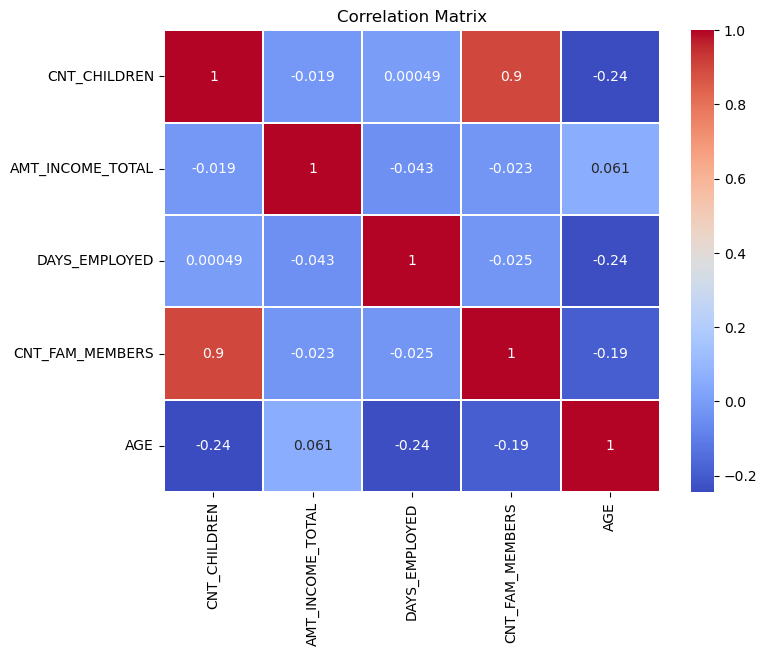

In [35]:
# Compute correlation matrix
correlation_matrix = application_record_df[numerical_cols].corr()

# Plot heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.25)
plt.title('Correlation Matrix')
plt.show()

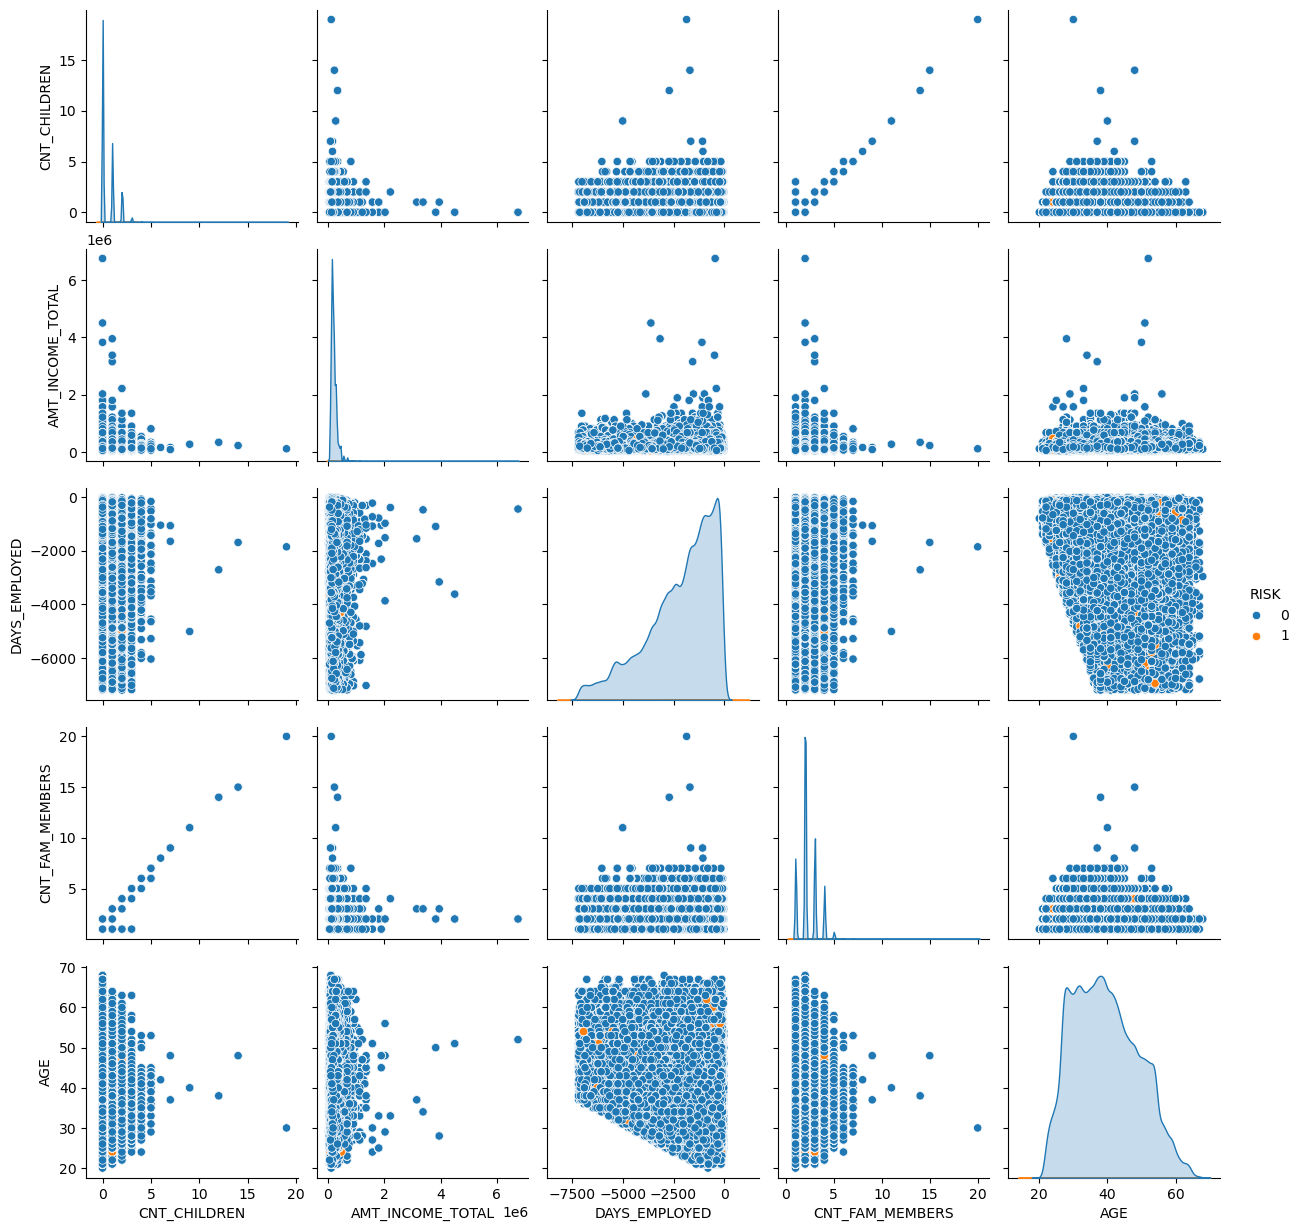

In [36]:
sns.pairplot(application_record_df[numerical_cols+ ['RISK']], hue='RISK')

The plots does not provide us with any very useful information. However, just for clarification note that the correlation between **AGE** and **DAYS_EMPLOYED** is negative, which makes sense since negative numbers in **DAYS_EMPLOYED** is days the customer has been employed. Thus, as **AGE** increases the number of days a customer has been employed do also increase.

#### Binary


Counts of Categories in FLAG_OWN_CAR:
 RISK               0    1
FLAG_OWN_CAR             
0             199453  284
1             141247  197


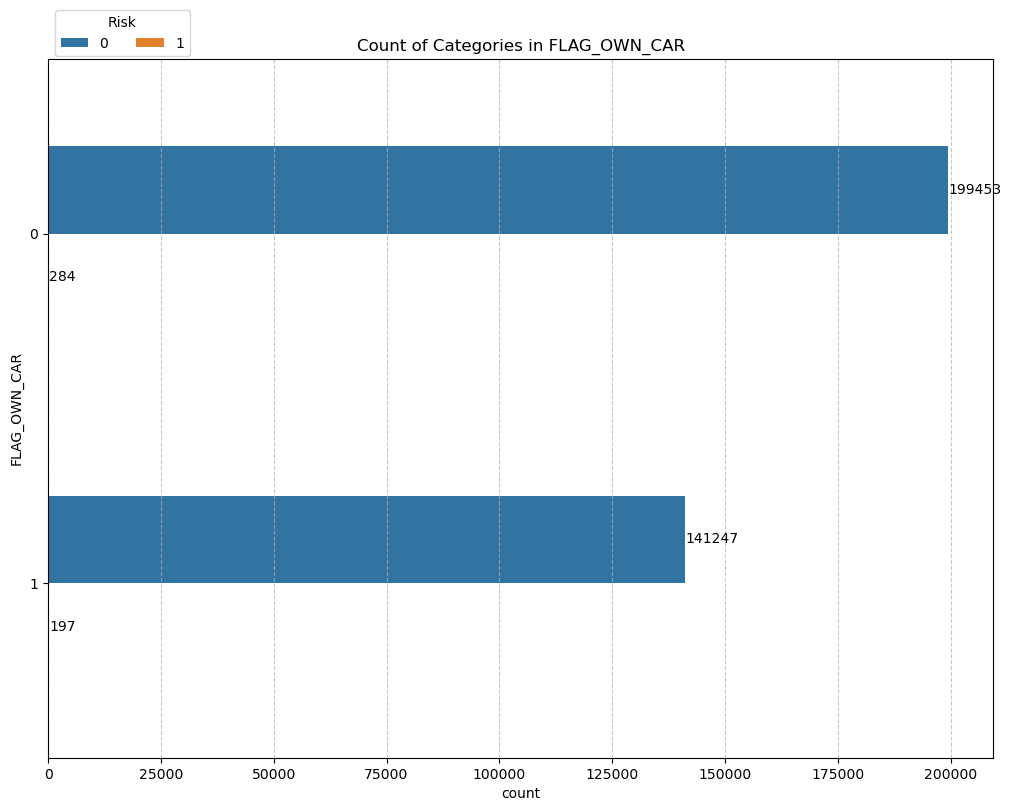


Counts of Categories in FLAG_OWN_REALTY:
 RISK                  0    1
FLAG_OWN_REALTY             
0                109987  201
1                230713  280


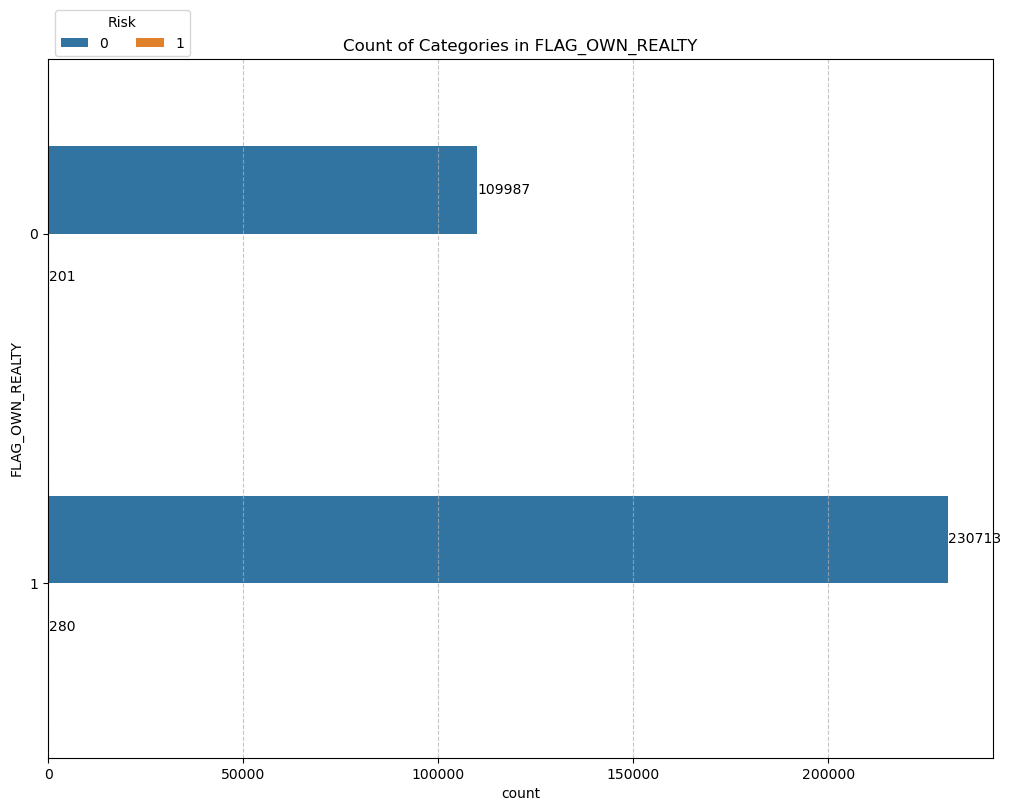


Counts of Categories in FLAG_MOBIL:
 RISK             0    1
FLAG_MOBIL             
1           340700  481


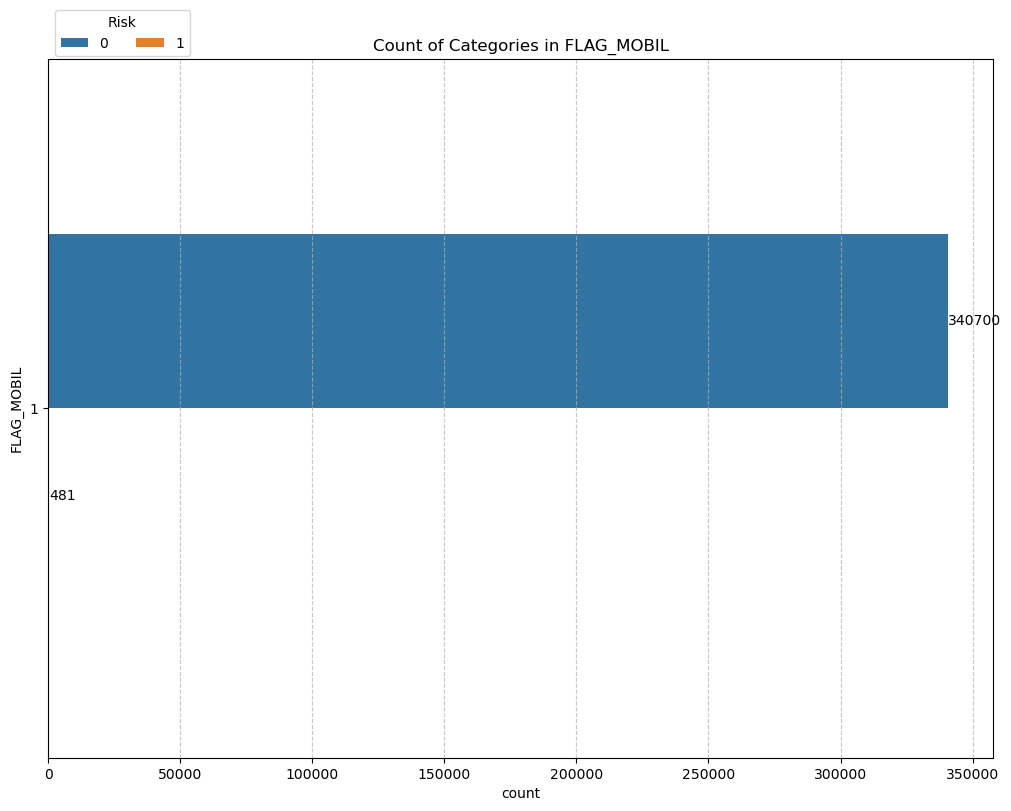


Counts of Categories in FLAG_WORK_PHONE:
 RISK                  0    1
FLAG_WORK_PHONE             
0                256419  337
1                 84281  144


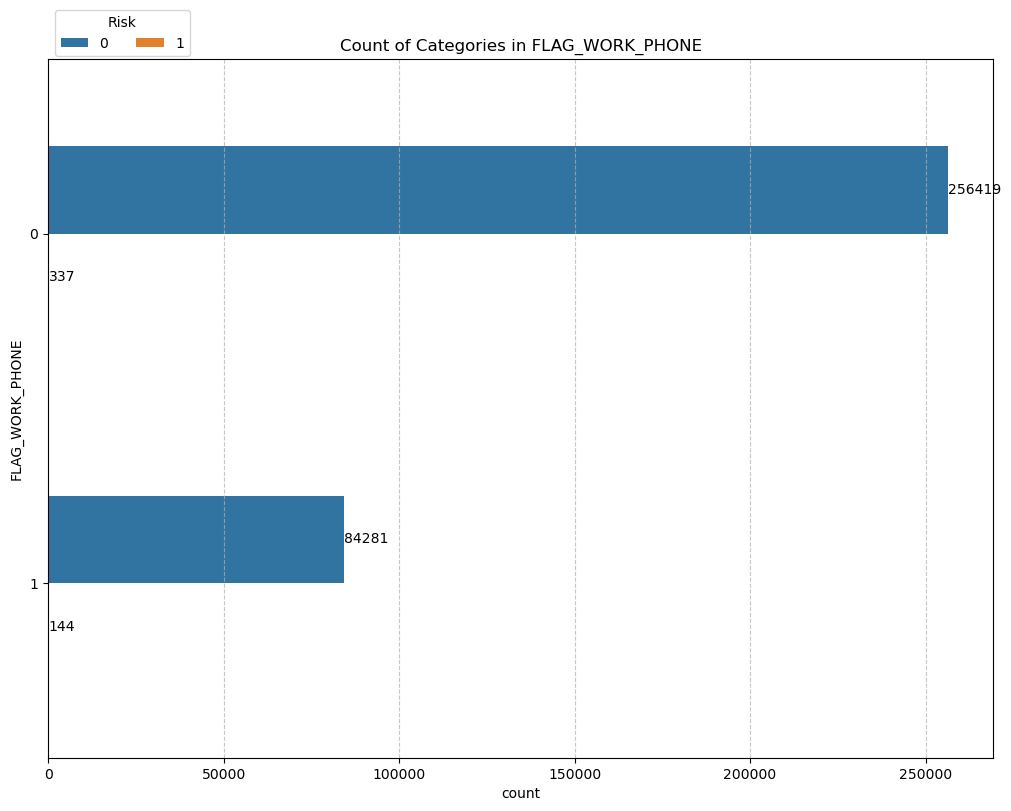


Counts of Categories in FLAG_PHONE:
 RISK             0    1
FLAG_PHONE             
0           244325  330
1            96375  151


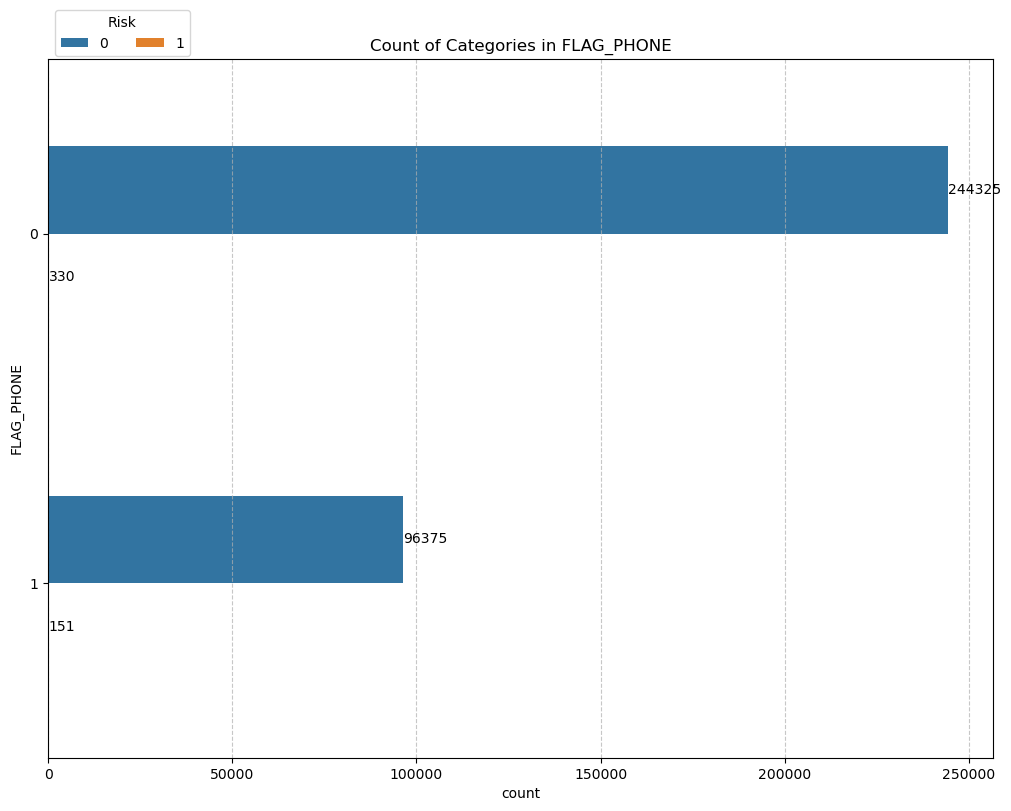


Counts of Categories in FLAG_EMAIL:
 RISK             0    1
FLAG_EMAIL             
0           299300  434
1            41400   47


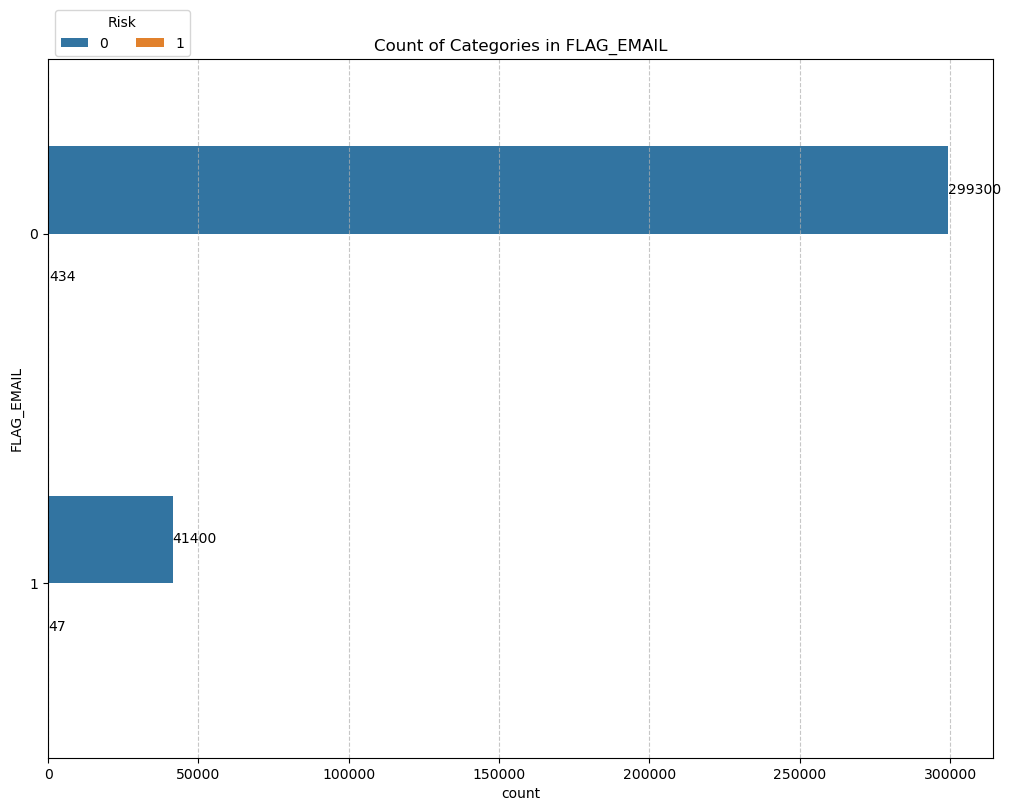

In [37]:
for column in binary_cols:
    # Group and count data by category and risk
    category_counts = application_record_df.groupby([column, 'RISK']).size().unstack(fill_value=0)

    # Display the counts DataFrame
    print(f"\nCounts of Categories in {column}:\n", category_counts)

    # Create a plot with a fixed size
    fig, ax = plt.subplots(figsize=(10, 8), constrained_layout=True)

    # Create a count plot with seaborn
    sns.countplot(data=application_record_df, y=column, hue='RISK', ax=ax, width=0.5)

    # Add bar labels to each bar
    for container in ax.containers:
        ax.bar_label(container)

    # Adjust the legend position above the left corner of the plot
    ax.legend(
        loc='upper left',
        ncol=2,
        bbox_to_anchor=(0, 1.08),  # Fine-tune the position to be just above the plot's left corner
        title='Risk'
    )

    # Add title and gridlines
    ax.set_title(f'Count of Categories in {column}')
    ax.grid(axis='x', linestyle='--', alpha=0.7)

    # Display the plot
    plt.show()

#### Summary of EDA
We did not get much useful information from our EDA. However, we did find some clear errors, which we removed from the dataset. 

Lets move on to the last preprocessing of our dataset before we are ready to start training some models.

## Feature Engineering & Preprocessing
Now we'll do our last preprocessing to make the data ready to be trained on. This include one-hot encoding, scaling and splitting up our data into training-, validation- and test-set.

In [36]:
# Separate the response variable from the features
target = 'RISK'
Y = application_record_df[target]
x = application_record_df.drop(columns=[target])

In [37]:
# Convert categorical features into numerical format
encoder = OneHotEncoder()
encodedCol = encoder.fit_transform(application_record_df[categorical_cols]).toarray()
encoded_df = pd.DataFrame(encodedCol, columns=encoder.get_feature_names_out(categorical_cols))
x = x.drop(categorical_cols, axis=1)
x.reset_index(inplace=True)
x = pd.concat([x, encoded_df], axis=1)
x.set_index('ID', inplace=True)
x

,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,...,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Unemployed,OCCUPATION_TYPE_Waiters/barmen staff
ID,,,,,,,,,,,,,,,,,,,,,
5008804,1,1,0,427500.0,-4542,1,1,0,0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5008805,1,1,0,427500.0,-4542,1,1,0,0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5008806,1,1,0,112500.0,-1134,1,0,0,0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5008808,0,1,0,270000.0,-3051,1,0,1,1,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5008809,0,1,0,270000.0,-3051,1,0,1,1,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6839917,0,1,0,180000.0,-2704,1,0,0,0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6839936,1,1,1,135000.0,-2095,1,0,0,0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6840222,0,0,0,103500.0,-3007,1,0,0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
# Split data into traning and test sets
X_train, X_temp, Y_train, Y_temp = train_test_split(x, Y, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

In [39]:
print('X_train shape    : ', X_train.shape)
print('Y_train shape    : ', Y_train.shape)
print('X_val shape      : ', X_val.shape)
print('Y_val shape      : ', Y_val.shape)
print('X_test shape     : ', X_test.shape)
print('Y_test shape     : ', Y_test.shape)

X_train shape    :  (272944, 53)
Y_train shape    :  (272944,)
X_val shape      :  (34118, 53)
Y_val shape      :  (34118,)
X_test shape     :  (34119, 53)
Y_test shape     :  (34119,)


In [40]:
# Scale numerical features
scaler = StandardScaler()
scaler.fit(X_train[numerical_cols])

# Transform the training data
X_train_scaled = X_train.copy()
X_train_scaled[numerical_cols] = scaler.transform(X_train[numerical_cols])

# Transform the validation data
X_val_scaled = X_val.copy()
X_val_scaled[numerical_cols] = scaler.transform(X_val[numerical_cols])

# Transform the test data
X_test_scaled = X_test.copy()
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

## Model Selection
We will try out the following kinds of algorithms to see, which one performs the best:
1. Random Forest
1. XGBoost
1. Neural Network 

However, before we begin we must figure out, which metric we evaluate our models on. 

For imbalanced data, **accuracy** will not be the best to evaluate our models on, since it could find none of the 'risky' customers but still get a very high accuracy. 
<br>**Recall** however, would be a better metric, since we then would try to find as many risky customers as possible. But only looking at recall would result in a lot of good customers getting predicted as risky. Thus, we would also need to factor in the **precision**. This leads us to the **F1** metric. With the F1 metric we try to predict as many risky customers as possible while minimize the number of good customers getting predicted as risky customers, which is essentially what we want.


In [41]:
# The scores we want to look at
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0)
}

Lets also create some functions to print out some results

In [42]:
# Function for plotting a confusion matrix and print the recall, precision and f1 score 
def get_result(predictions, threshold: int):
    y_pred = (predictions > threshold).astype(int)

    cm = confusion_matrix(Y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    recall = recall_score(Y_test, y_pred)
    precision = precision_score(Y_test, y_pred)
    f1 = f1_score(Y_test, y_pred)
    print('Recall       =', round(recall, 2))
    print('Precision    =', round(precision, 2))
    print('F1           =', round(f1, 2))

# Function for plotting how the different threshold affects the metrics and return the threshold resulting in the highest f1 score
def plot_precision_recall_vs_threshold(name, true_labels, predictions):
    # Calculate the precision and recall
    precision, recall, thresholds = precision_recall_curve(true_labels, predictions)

    # Calculate the f1 scores
    f1_scores = 2 * (precision * recall) / (precision + recall)
    f1_scores = np.nan_to_num(f1_scores, nan=0.0)  # Replace NaN with 0

    # Find the index of the maximum F1 score
    best_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_index]

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precision[:-1], label=name + ' Precision', marker='.', color='Red')
    plt.plot(thresholds, recall[:-1], label=name + ' Recall', marker='.', color='Blue')
    plt.plot(thresholds, f1_scores[:-1], label=name + ' F1 Score', marker='.', color='Green')

    # Add a vertical line at the best threshold
    plt.axvline(x=best_threshold, color='grey', linestyle='--', label=f'Best Threshold: {best_threshold:.4f}')

    plt.xlabel('Threshold')
    plt.ylabel('Rate')
    plt.title('Overview')
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()
    
    return best_threshold

# Function for plotting the ROC curve
def plot_roc_curve(y_true, y_probs):
    # Calculate the False Positive Rate and True Positive Rate
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    
    # Calculate the Area Under the ROC Curve (AUC)
    roc_auc = auc(fpr, tpr)
    
    # Plotting the ROC curve
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color="blue", label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Diagonal line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title('ROC Curve')
    plt.legend(loc="center right")
    plt.grid(True)
    plt.show()

### Random Forest

In [80]:
from sklearn.ensemble import RandomForestClassifier

#### Hyperparameter Tuning
Here we set up the hyperparameters we want to tune

In [110]:
param_grid = {
    'n_estimators': [50, 100, 250, 500],        # Number of trees
    'max_depth': [None, 10, 25, 50],            # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],            # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],              # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2'],           # Number of features to consider at each split
    'bootstrap': [True, False],                 # Method of selecting samples for training each tree
    'class_weight' : [None, 'balanced']         # Weights associated with classes (for imbalance)
}

In [112]:
# Initialize the RandomForestClassifier
rfc = RandomForestClassifier()

# Initialize RandomizedSearchCV
rfc_random = RandomizedSearchCV(estimator=rfc, param_distributions=param_grid, 
                               n_iter=50, cv=3, verbose=1, random_state=42, n_jobs=-1,
                               scoring=scoring, refit='f1') # We use f1 for the refit to find the parameters that maximize that


In [113]:
# Run the RandomizedSearchCV
rfc_random.fit(X_train_scaled, Y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/home/ykh/miniconda3/envs/tfgpu/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': [None, 'balanced'],
                                        'max_depth': [None, 10, 25, 50],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 250, 500]},
                   random_state=42, refit='f1',
                   scoring={'accuracy': 'accuracy',
                            'f1': make_scorer(f1_score, response_method='predict', zero_division=0),
                            'precision': make_scorer(precision_score, response_method='predict', zero_division=0),
                            'recall': make_scorer(recall_score, response_method='predict', zero_division=0)},
                   verbose=1)

In [114]:
# Look at the results of the hyperparameter tuning
rfc_random_result_df = pd.DataFrame(rfc_random.cv_results_['params'])
rfc_random_result_df['Mean_Accuracy'] = rfc_random.cv_results_['mean_test_accuracy']
rfc_random_result_df['Mean_Recall'] = rfc_random.cv_results_['mean_test_recall']
rfc_random_result_df['Mean_Precision'] = rfc_random.cv_results_['mean_test_precision']
rfc_random_result_df['Mean_f1'] = rfc_random.cv_results_['mean_test_f1']
rfc_random_result_df['Rank_Recall'] = rfc_random.cv_results_['rank_test_recall']
rfc_random_result_df['Rank_Precision'] = rfc_random.cv_results_['rank_test_precision']
rfc_random_result_df['Rank_F1'] = rfc_random.cv_results_['rank_test_f1']
rfc_random_result_df.sort_values('Rank_F1')

,n_estimators,min_samples_split,min_samples_leaf,max_features,max_depth,class_weight,bootstrap,Mean_Accuracy,Mean_Recall,Mean_Precision,Mean_f1,Rank_Recall,Rank_Precision,Rank_F1
43,100,2,4,sqrt,NaN,balanced,False,0.997117,0.361979,0.205128,0.261724,1,15,1
44,50,2,4,sqrt,NaN,balanced,False,0.997135,0.356771,0.204693,0.260019,4,16,2
39,100,10,2,log2,NaN,balanced,False,0.997128,0.354167,0.202982,0.258011,10,22,3
38,500,10,4,sqrt,50.0,balanced,True,0.997164,0.348958,0.204396,0.257710,11,17,4
7,250,2,2,log2,50.0,balanced,True,0.997172,0.346354,0.204095,0.256755,12,18,5
26,50,10,4,sqrt,NaN,balanced,False,0.997087,0.356771,0.200446,0.256647,4,27,6
28,500,2,4,log2,50.0,balanced,False,0.997080,0.356771,0.199978,0.256274,4,30,7
30,50,10,4,sqrt,25.0,balanced,True,0.997230,0.338542,0.206243,0.256257,20,14,8
8,500,2,4,log2,NaN,balanced,True,0.997161,0.346354,0.203225,0.256042,12,20,9
42,100,5,1,log2,50.0,balanced,False,0.997161,0.346354,0.203158,0.256013,12,21,10


From the results above, we can see that using class_weight='balanced' is clearly best, which is not surprising, since we have a imbalanced dataset. 
<br>Next, we see that the higher values for min_samples_leaf is in the top. You could try to tune some more, with some higher values in min_samples_leaf, if you wanna see how much it could improve the model. We will not do that here.
<br>Note also the accuracy for every model. The vast majority got an accuracy of 99% and even the models not predicting 1 risky customer right got it. 

Lets take the model with the hyperparameters that performed the best and test it on our test set and see how well it is doing.

In [115]:
# Evaluate the Best Model
print(f"Best Parameters: {rfc_random.best_params_}")
best_rf = rfc_random.best_estimator_

Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': 'balanced', 'bootstrap': False}


In [116]:
# Predict on the test set
y_pred = best_rf.predict(X_test_scaled)

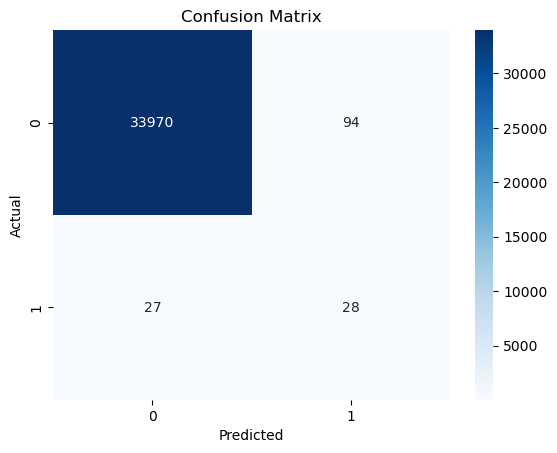

In [117]:
cm = confusion_matrix(Y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [122]:
print('Recall       =', round(recall_score(Y_test, y_pred), 2))
print('Precision    =', round(precision_score(Y_test, y_pred), 2))
print('F1           =', round(f1_score(Y_test, y_pred), 2))

Recall       = 0.51
Precision    = 0.23
F1           = 0.32


For training this model we did not use the validation set, which contains 10% of the original dataset. It could be interresting to see if the model, with the same parameters, could perform better on the test set if it had more data to train on.

Lets merge the training and validation set and predict on the test set again.

In [128]:
# Initialize the RandomForestClassifier with the best hyperparameters from the tuning phase
rfc = RandomForestClassifier(n_estimators=100,
                             min_samples_split=2,
                             min_samples_leaf=4,
                             max_features='sqrt',
                             max_depth=None,
                             class_weight='balanced',
                             bootstrap=False)

In [129]:
# Train the model
rfc.fit(pd.concat([X_train_scaled, X_val_scaled]), pd.concat([Y_train, Y_val]))

RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       min_samples_leaf=4)

In [130]:
# Predict on the test set
y_pred = rfc.predict(X_test_scaled)

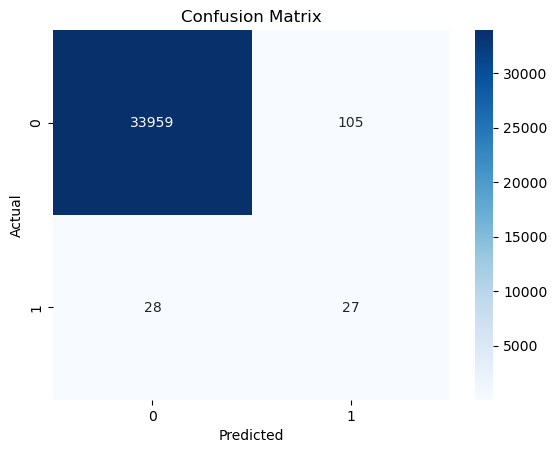

In [131]:
cm = confusion_matrix(Y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [132]:
print('Recall       =', round(recall_score(Y_test, y_pred), 2))
print('Precision    =', round(precision_score(Y_test, y_pred), 2))
print('F1           =', round(f1_score(Y_test, y_pred), 2))

Recall       = 0.49
Precision    = 0.2
F1           = 0.29


Unfortunately that made the model worse. Other hyperparameters could perhaps make it better. However, we will take the results from the model we found through hyperparameter tuning and use that in the comparison with the other models. 

**The result was the following:**

- Recall = 0.51
- Precision = 0.23
- F1 = 0.32

### XGBoost

In [42]:
from xgboost import XGBClassifier

#### Hyperparameter Tuning

In [52]:
# We'll need the count of each class for a hyperparameter
risk_count = application_record_df['RISK'].value_counts() 

In [53]:
param_grid = {
    'n_estimators': [100, 250, 500, 1000],      # Number of trees
    'max_depth': [5, 10, 25, 75],               # Maximum depth of a tree
    'learning_rate': [0.1, 0.5, 1, 2.5],        # Step size shrinkage used in update to prevent overfitting
    'objective': ['binary:logistic'],           # The learning task and the corresponding learning objective
    'eval_metric': ['aucpr'],                   # Evaluation metrics for validation data
    'scale_pos_weight': [1, 100, 250, 500,      # Control the balance of positive and negative weights
                         risk_count[0]/risk_count[1]] # Typical value to consider
}

In [54]:
# Initialize the RandomForestClassifier
xgb = XGBClassifier()

# Initialize RandomizedSearchCV
xgb_random = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid, 
                               n_iter=50, cv=3, verbose=1, random_state=42, n_jobs=-1,
                               scoring=scoring, refit='f1')


In [55]:
xgb_random.fit(X_train_scaled, Y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'scale_pos_weight': [1, 100, 250, 500,
                                                             708.3160083160083]},
                   random_state=42, refit='f1',
                   scoring={'accuracy': 'accuracy',
                            'f1': make_scorer(f1_score, response_method='predict', zero_division=0),
                            'precision': make_scorer(precision_score, response_method='predict', zero_division=0),
                            'recall': make_scorer(recall_score, response_method='predict', zero_division=0)},
                   verbose=1)

In [56]:
# Look at the results of the hyperparameter tuning
xgb_random_result_df = pd.DataFrame(xgb_random.cv_results_['params'])
xgb_random_result_df['Mean_Accuracy'] = xgb_random.cv_results_['mean_test_accuracy']
xgb_random_result_df['Mean_Recall'] = xgb_random.cv_results_['mean_test_recall']
xgb_random_result_df['Mean_Precision'] = xgb_random.cv_results_['mean_test_precision']
xgb_random_result_df['Mean_f1'] = xgb_random.cv_results_['mean_test_f1']
xgb_random_result_df['Rank_Recall'] = xgb_random.cv_results_['rank_test_recall']
xgb_random_result_df['Rank_Precision'] = xgb_random.cv_results_['rank_test_precision']
xgb_random_result_df['Rank_F1'] = xgb_random.cv_results_['rank_test_f1']
xgb_random_result_df.sort_values('Rank_F1')

,scale_pos_weight,objective,n_estimators,max_depth,learning_rate,eval_metric,Mean_Accuracy,Mean_Recall,Mean_Precision,Mean_f1,Rank_Recall,Rank_Precision,Rank_F1
47,708.316008,binary:logistic,500,10,1.0,aucpr,0.997216,0.393229,0.223354,0.284750,4,8,1
41,500.000000,binary:logistic,500,10,1.0,aucpr,0.997208,0.388021,0.221015,0.281494,6,9,2
22,500.000000,binary:logistic,1000,10,1.0,aucpr,0.997208,0.388021,0.221015,0.281494,6,9,2
29,500.000000,binary:logistic,100,10,1.0,aucpr,0.997205,0.388021,0.220790,0.281334,6,11,4
0,250.000000,binary:logistic,250,5,1.0,aucpr,0.997142,0.393229,0.217004,0.279533,4,17,5
14,250.000000,binary:logistic,500,5,1.0,aucpr,0.997179,0.388021,0.218494,0.279375,6,13,6
19,708.316008,binary:logistic,100,10,0.5,aucpr,0.997175,0.388021,0.218164,0.279138,6,14,7
27,500.000000,binary:logistic,500,10,0.1,aucpr,0.997194,0.385417,0.218852,0.279047,12,12,8
49,250.000000,binary:logistic,1000,5,1.0,aucpr,0.997175,0.385417,0.217267,0.277744,12,16,9
15,708.316008,binary:logistic,1000,10,0.5,aucpr,0.997186,0.382812,0.217395,0.277117,14,15,10


In [57]:
# Evaluate the Best Model
print(f"Best Parameters: {xgb_random.best_params_}")
best_xgb = xgb_random.best_estimator_

Best Parameters: {'scale_pos_weight': 708.3160083160083, 'objective': 'binary:logistic', 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 1, 'eval_metric': 'aucpr'}


In [62]:
# Save the best model
best_xgb.save_model('xgb_best_model.json')

In [58]:
# Predict on the test set
y_pred = best_xgb.predict(X_test_scaled)

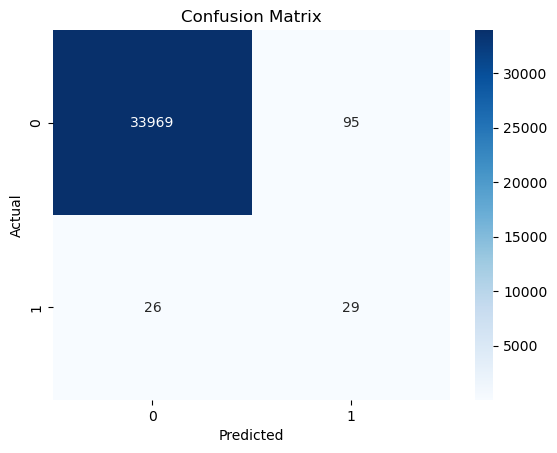

In [65]:
# Create a confusion matrix
cm = confusion_matrix(Y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [66]:
recall_1 = recall_score(Y_test, y_pred)
precision_1 = precision_score(Y_test, y_pred)
f1_1 = f1_score(Y_test, y_pred)
print('Recall       =', round(recall_1, 2))
print('Precision    =', round(precision_1, 2))
print('F1           =', round(f1_1, 2))

Recall       = 0.53
Precision    = 0.23
F1           = 0.32


Lets again merge the training and validation set and predict on the test set to see if the model can perform better with more training data.



In [76]:
# Initialize the RandomForestClassifier with the best hyperparameters from the tuning phase
xgb = XGBClassifier(
    n_estimators = xgb_random.best_params_['n_estimators'],
    max_depth = xgb_random.best_params_['max_depth'],
    learning_rate = xgb_random.best_params_['learning_rate'],
    objective = xgb_random.best_params_['objective'],
    eval_metric = xgb_random.best_params_['eval_metric'],
    scale_pos_weight = xgb_random.best_params_['scale_pos_weight']
)

In [77]:
# Train the model
xgb.fit(pd.concat([X_train_scaled, X_val_scaled]), pd.concat([Y_train, Y_val]))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [78]:
y_pred = xgb.predict(X_test_scaled)

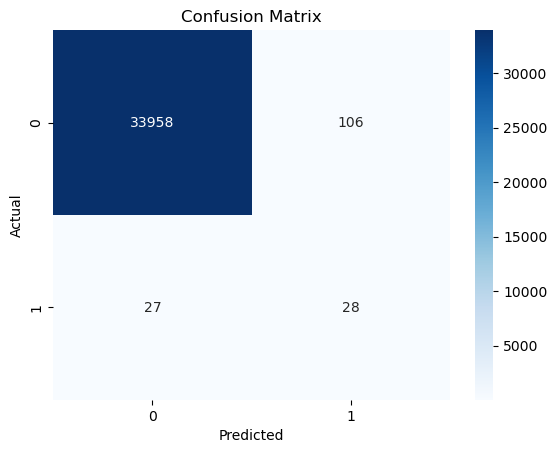

In [79]:
cm = confusion_matrix(Y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [80]:
recall_2 = recall_score(Y_test, y_pred)
precision_2 = precision_score(Y_test, y_pred)
f1_2 = f1_score(Y_test, y_pred)
print('Recall       =', round(recall_2, 2))
print('Precision    =', round(precision_2, 2))
print('F1           =', round(f1_2, 2))

Recall       = 0.51
Precision    = 0.21
F1           = 0.3


In [85]:
if f1_2 > f1_1:
    xgb.save_model('xgb_best_model.json')
    print('By training our model on more data, we achived a higher performance')
else:
    print('The first model we found, through hyperparameter tuning, is still our best model.')
    print('It had the following scores:')
    print('Recall       =', round(recall_1, 2))
    print('Precision    =', round(precision_1, 2))
    print('F1           =', round(f1_1, 2))

The first model we found, through hyperparameter tuning, is still our best model.
It had the following scores:
Recall       = 0.53
Precision    = 0.23
F1           = 0.32


### Neural Network

In [81]:
import tensorflow as tf
from keras import Sequential, models, utils
import keras_tuner as kt
from keras.layers import Dense, Dropout, BatchNormalization
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy, Precision, Recall, F1Score, AUC
from keras.regularizers import l2
from keras.optimizers import Adam

In [45]:
BATCH_SIZE = 1024

We will start by creating a function to produce some plots of the models performance and loss on the training and validation set. These will help us check for overfitting.

In [46]:
def plot_training_metrics(history):
    metrics = ['loss', 'Recall', 'Precision', 'PRC']
    plt.figure(figsize=(12, 8))

    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        plt.plot(history.epoch, history.history[metric], label='Train')
        plt.plot(history.epoch, history.history['val_' + metric], label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()

    plt.tight_layout()
    plt.show()

Now, lets do an experiment of how our neural network would do, when we do not handle the imbalance in our dataset. Afterwards we'll try two different techniques to handle the imbalance.

We'll create a function to create a simple model, which we can use for this experiment.

In [98]:
def get_simple_model():
    model = Sequential()
    model.add(Dense(64, input_shape=(X_train_scaled.shape[1],)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(),
                    loss=BinaryCrossentropy(from_logits=False),
                    metrics=[
                        BinaryAccuracy(name='Accuracy'),
                        Precision(name='Precision'), 
                        Recall(name='Recall'), 
                        AUC(name='PRC', curve='PR')
                    ])

    return model

#### Without handling imbalance

In [99]:
model = get_simple_model()

In [100]:
history_unhandled = model.fit(
    X_train_scaled,
    Y_train,
    epochs=20,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_scaled, Y_val)
)

Epoch 1/20
267/267 [==============================] - 4s 11ms/step - loss: 0.0227 - Accuracy: 0.9950 - Precision: 0.0020 - Recall: 0.0052 - PRC: 0.0015 - val_loss: 0.0096 - val_Accuracy: 0.9988 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_PRC: 0.0013
Epoch 2/20
267/267 [==============================] - 3s 10ms/step - loss: 0.0106 - Accuracy: 0.9986 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - PRC: 0.0019 - val_loss: 0.0094 - val_Accuracy: 0.9988 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_PRC: 0.0016
Epoch 3/20
267/267 [==============================] - 3s 10ms/step - loss: 0.0103 - Accuracy: 0.9986 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - PRC: 0.0051 - val_loss: 0.0095 - val_Accuracy: 0.9988 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_PRC: 0.0035
Epoch 4/20
267/267 [==============================] - 2s 9ms/step - loss: 0.0102 - Accuracy: 0.9986 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - PRC: 0.0124 - val_loss: 0.0096 - val_Accur

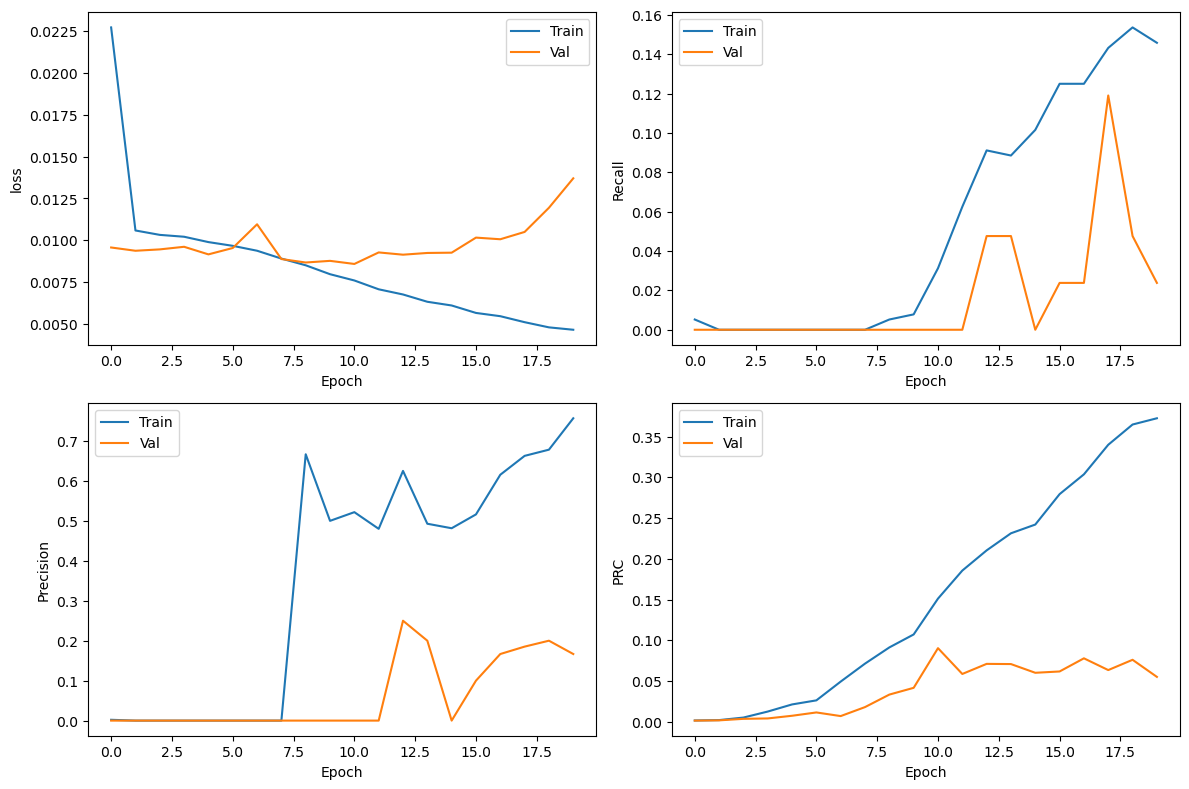

In [101]:
plot_training_metrics(history_unhandled)

In [102]:
train_predictions = model.predict(X_train_scaled, batch_size=BATCH_SIZE)
test_predictions = model.predict(X_test_scaled, batch_size=BATCH_SIZE)

34/34 [==============================] - 0s 2ms/step


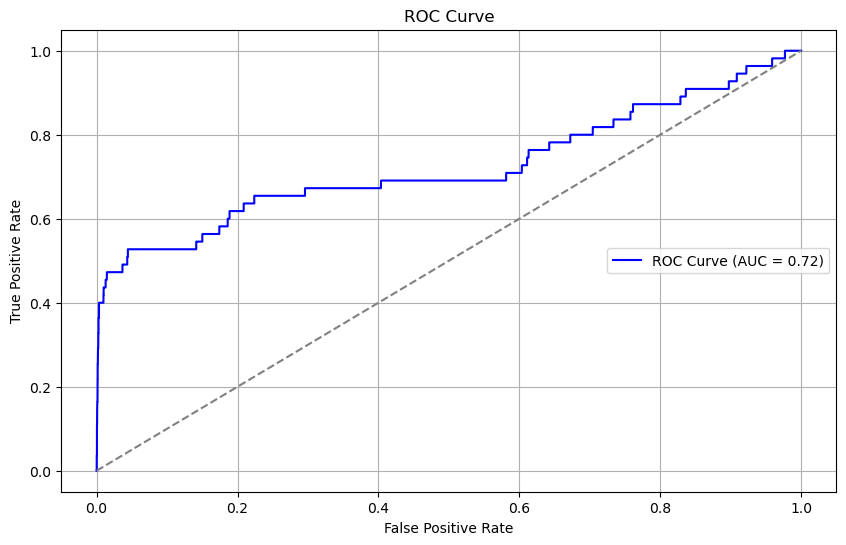

In [103]:
plot_roc_curve(Y_test, test_predictions)

/tmp/ipykernel_67979/1574870596.py:26: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


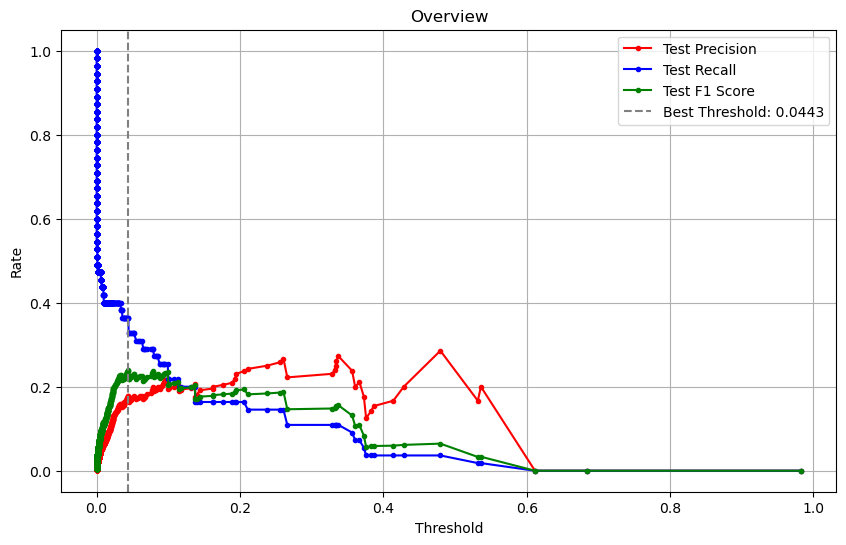

In [104]:
best_threshold = plot_precision_recall_vs_threshold('Test', Y_test, test_predictions)

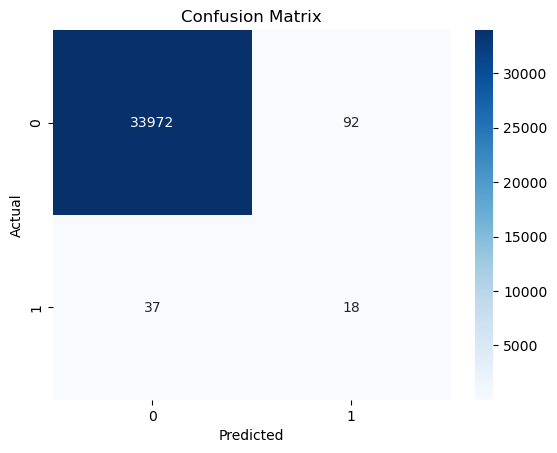

Recall       = 0.33
Precision    = 0.16
F1           = 0.22


In [105]:
get_result(test_predictions, best_threshold)

#### Test class weights

In [106]:
# Calculate class weights to handle imbalance
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(Y_train), y=Y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
class_weights_dict

{0: 0.5007044320516584, 1: 355.3958333333333}

In [121]:
model = get_simple_model()

In [122]:
history_class_weights = model.fit(
    X_train_scaled,
    Y_train,
    class_weight=class_weights_dict,
    epochs=20,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_scaled, Y_val)
)

Epoch 1/20
267/267 [==============================] - 4s 11ms/step - loss: 0.6967 - Accuracy: 0.5615 - Precision: 0.0017 - Recall: 0.5339 - PRC: 0.0018 - val_loss: 0.6743 - val_Accuracy: 0.6534 - val_Precision: 0.0019 - val_Recall: 0.5476 - val_PRC: 0.0020
Epoch 2/20
267/267 [==============================] - 3s 10ms/step - loss: 0.6621 - Accuracy: 0.4669 - Precision: 0.0019 - Recall: 0.7292 - PRC: 0.0029 - val_loss: 0.6507 - val_Accuracy: 0.7804 - val_Precision: 0.0021 - val_Recall: 0.3810 - val_PRC: 0.0042
Epoch 3/20
267/267 [==============================] - 3s 9ms/step - loss: 0.6446 - Accuracy: 0.6327 - Precision: 0.0024 - Recall: 0.6302 - PRC: 0.0038 - val_loss: 0.6586 - val_Accuracy: 0.6893 - val_Precision: 0.0024 - val_Recall: 0.5952 - val_PRC: 0.0035
Epoch 4/20
267/267 [==============================] - 3s 10ms/step - loss: 0.6042 - Accuracy: 0.7186 - Precision: 0.0030 - Recall: 0.5964 - PRC: 0.0134 - val_loss: 0.6571 - val_Accuracy: 0.6335 - val_Precision: 0.0020 - val_Recall

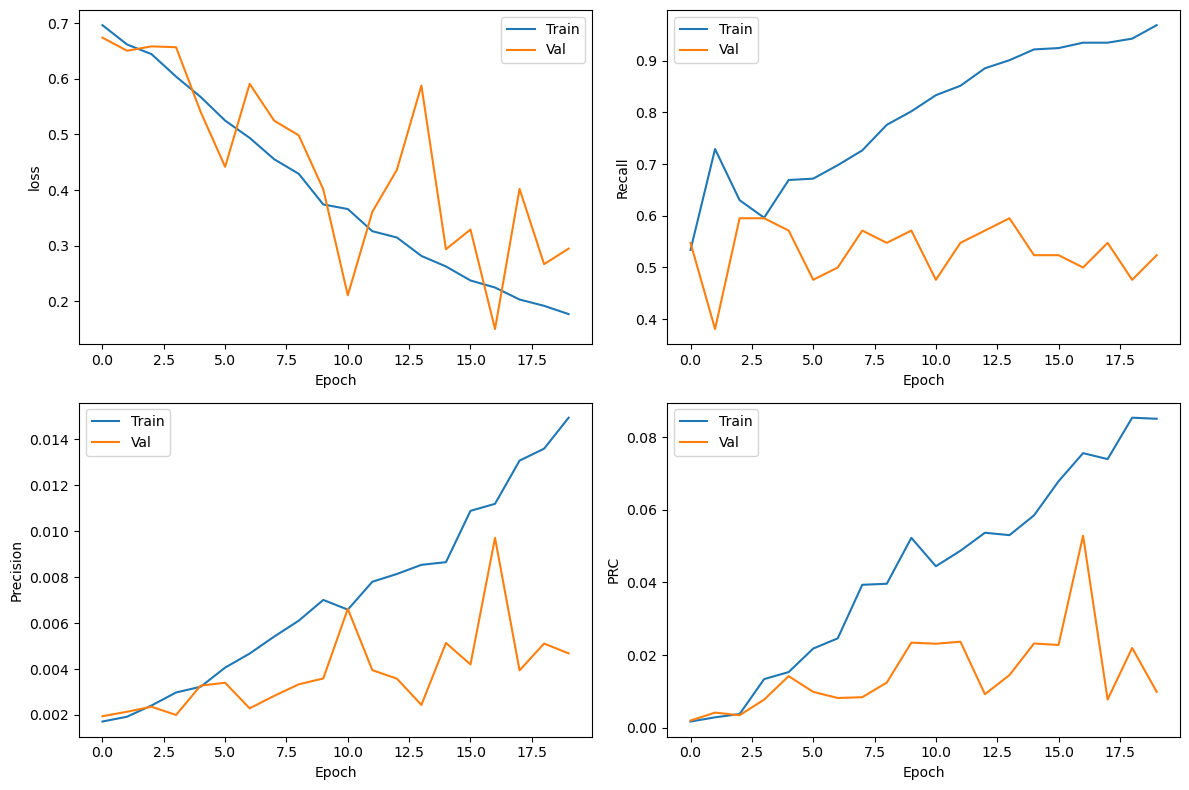

In [123]:
plot_training_metrics(history_class_weights)

In [124]:
train_predictions = model.predict(X_train_scaled, batch_size=BATCH_SIZE)
test_predictions = model.predict(X_test_scaled, batch_size=BATCH_SIZE)

34/34 [==============================] - 0s 2ms/step


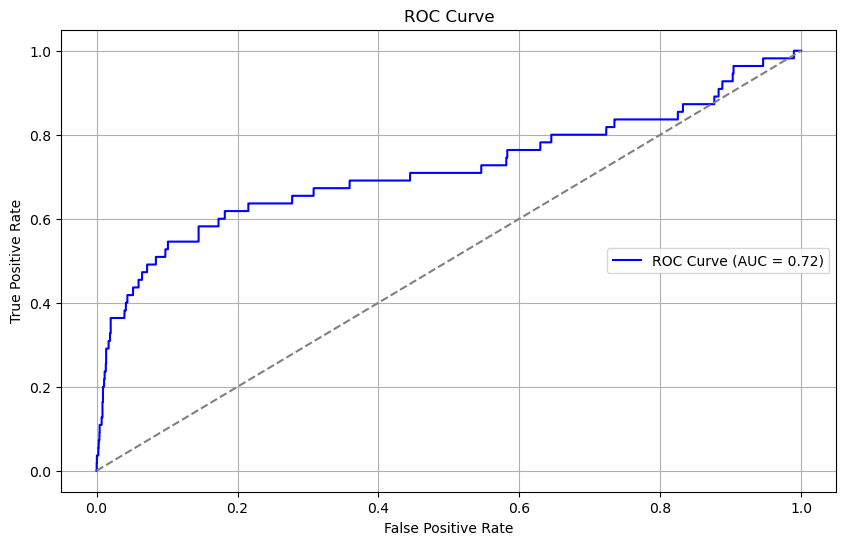

In [125]:
plot_roc_curve(Y_test, test_predictions)

/tmp/ipykernel_67979/1574870596.py:26: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


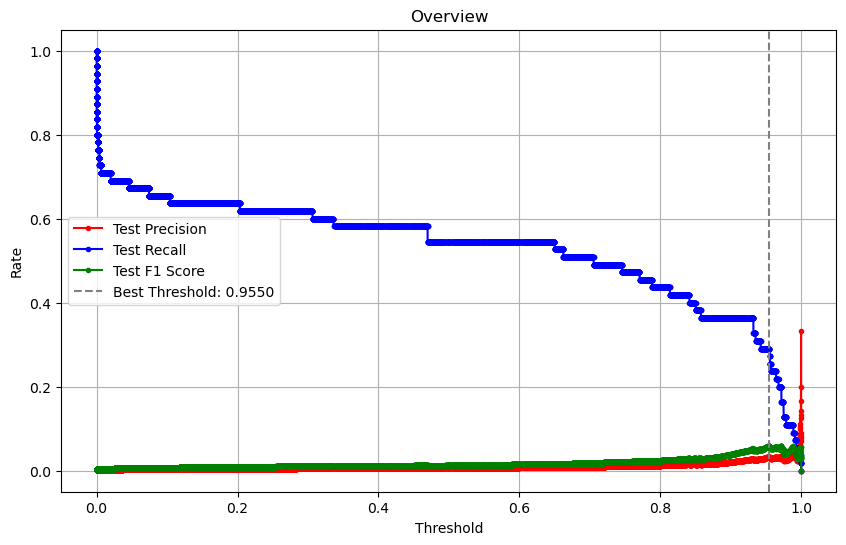

In [126]:
best_threshold = plot_precision_recall_vs_threshold('Test', Y_test, test_predictions)

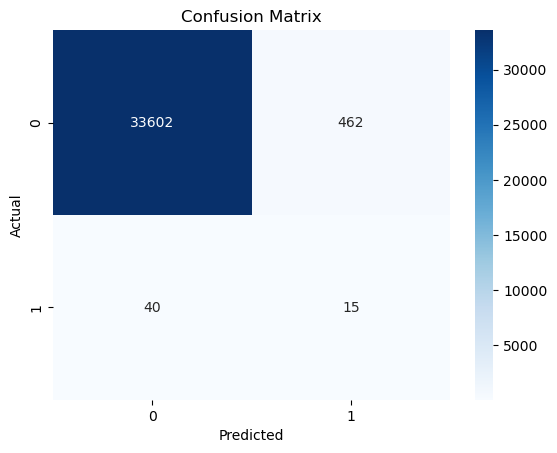

Recall       = 0.27
Precision    = 0.03
F1           = 0.06


In [127]:
get_result(test_predictions, best_threshold)

#### Test oversampling 

In [48]:
# Split the training set into normal and risky
X_train_scaled_normal = X_train_scaled[~X_train_scaled.index.isin(risk_ids)]
X_train_scaled_risk = X_train_scaled[X_train_scaled.index.isin(risk_ids)]

Y_train_normal = Y_train[~Y_train.index.isin(risk_ids)]
Y_train_risk = Y_train[Y_train.index.isin(risk_ids)]

print(f'Number of normal customers :', len(Y_train_normal))
print(f'Number of risky customers :', len(Y_train_risk))

Number of normal customers : 272560
Number of risky customers : 384


In [49]:
# Select risky customers at random until there is as many risky customers as normal customers 
choices = np.random.choice(X_train_scaled_risk.index, len(X_train_scaled_normal))

X_train_scaled_risk_oversampled = X_train_scaled_risk.loc[choices]
Y_train_risk_oversampled = Y_train_risk.loc[choices]

print(f'Number of risky customers (oversampled) :', X_train_scaled_risk_oversampled.shape)

Number of risky customers (oversampled) : (272560, 53)


In [50]:
# Merge the oversampled dataset with risky customers with the dataset containing normal customers 
X_train_scaled_oversampled = np.concatenate([X_train_scaled_normal, X_train_scaled_risk_oversampled], axis=0)
y_train_oversampled = np.concatenate([Y_train_normal, Y_train_risk_oversampled], axis=0)

In [51]:
# Shuffle the order of risky and normal customers
order = np.arange(len(y_train_oversampled))
np.random.shuffle(order)

X_train_scaled_oversampled = X_train_scaled_oversampled[order]
y_train_oversampled = y_train_oversampled[order]

In [128]:
model = get_simple_model()

In [129]:
history_oversampled = model.fit(
    X_train_scaled_oversampled,
    y_train_oversampled,
    epochs=20,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_scaled, Y_val)
)

Epoch 1/20
533/533 [==============================] - 6s 9ms/step - loss: 0.1086 - Accuracy: 0.9560 - Precision: 0.9469 - Recall: 0.9662 - PRC: 0.9910 - val_loss: 0.0947 - val_Accuracy: 0.9775 - val_Precision: 0.0249 - val_Recall: 0.4524 - val_PRC: 0.0450
Epoch 2/20
533/533 [==============================] - 5s 9ms/step - loss: 0.0216 - Accuracy: 0.9954 - Precision: 0.9919 - Recall: 0.9989 - PRC: 0.9970 - val_loss: 0.0395 - val_Accuracy: 0.9928 - val_Precision: 0.0756 - val_Recall: 0.4286 - val_PRC: 0.0542
Epoch 3/20
533/533 [==============================] - 5s 9ms/step - loss: 0.0171 - Accuracy: 0.9967 - Precision: 0.9940 - Recall: 0.9995 - PRC: 0.9971 - val_loss: 0.0423 - val_Accuracy: 0.9932 - val_Precision: 0.0762 - val_Recall: 0.4048 - val_PRC: 0.0515
Epoch 4/20
533/533 [==============================] - 5s 9ms/step - loss: 0.0161 - Accuracy: 0.9969 - Precision: 0.9944 - Recall: 0.9995 - PRC: 0.9972 - val_loss: 0.0389 - val_Accuracy: 0.9936 - val_Precision: 0.0810 - val_Recall: 0

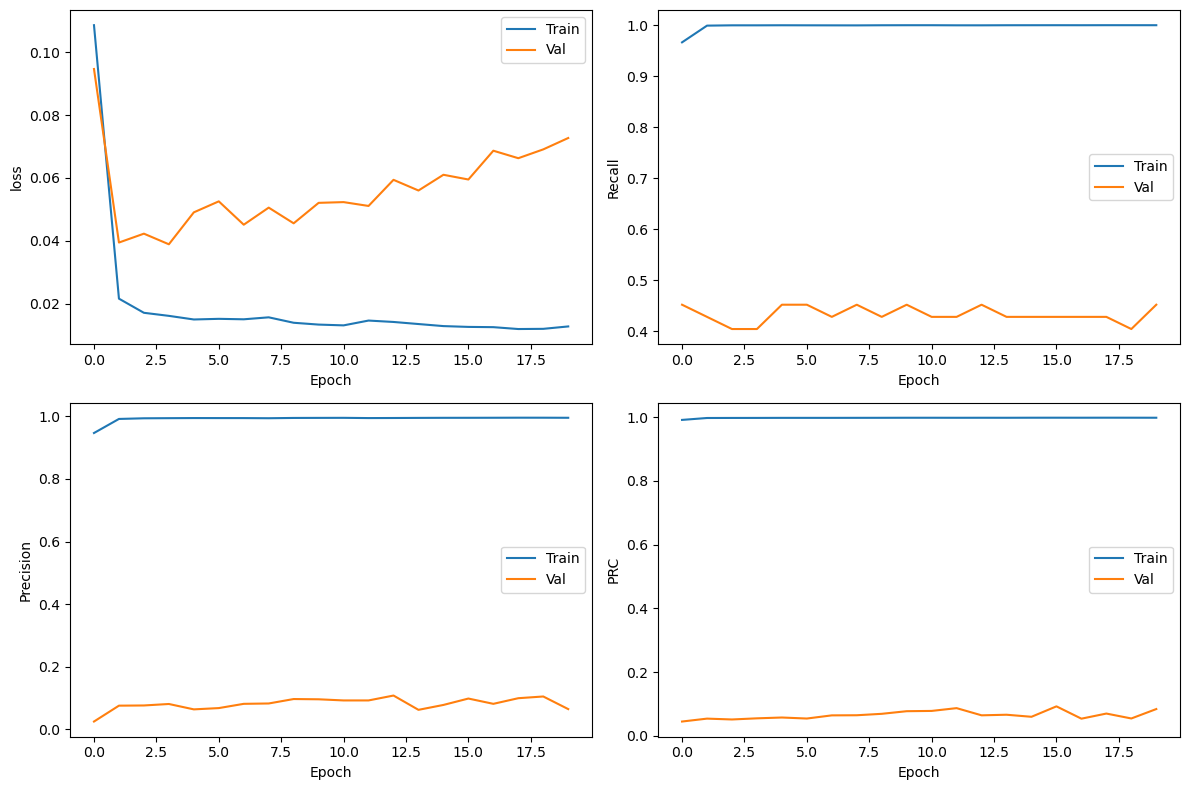

In [130]:
plot_training_metrics(history_oversampled)

In [131]:
train_predictions = model.predict(X_train_scaled, batch_size=BATCH_SIZE)
test_predictions = model.predict(X_test_scaled, batch_size=BATCH_SIZE)

34/34 [==============================] - 0s 1ms/step


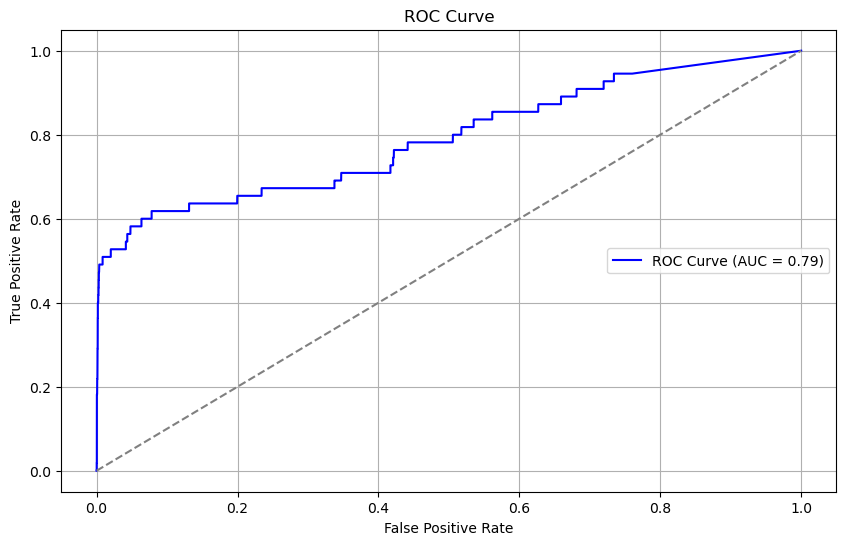

In [132]:
plot_roc_curve(Y_test, test_predictions)

/tmp/ipykernel_67979/1574870596.py:26: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


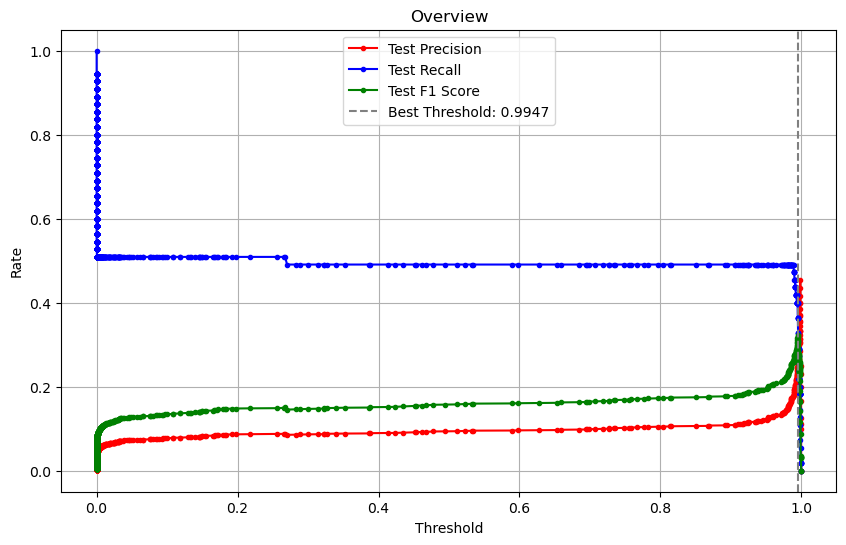

In [133]:
best_threshold = plot_precision_recall_vs_threshold('Test', Y_test, test_predictions)

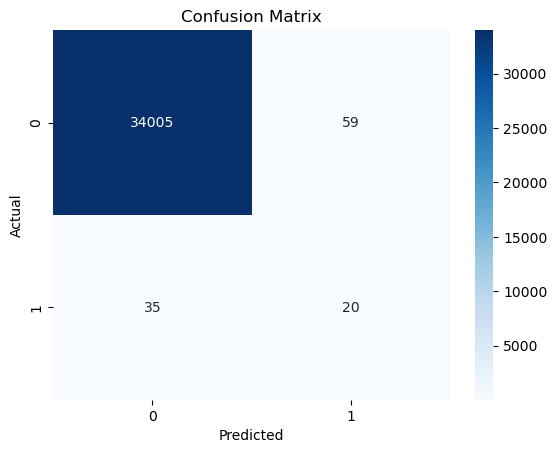

Recall       = 0.36
Precision    = 0.25
F1           = 0.3


In [134]:
get_result(test_predictions, best_threshold)

#### Find the best model

In [ ]:
def model_builder(hp):
    model = Sequential()
    model.add(Dense(units=16, input_shape=(X_train_scaled.shape[1],)))

    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(
            Dense(
                # Tune the number of units
                units=hp.Int(f"units_{i}", min_value=32, max_value=256, step=32),
                activation='relu'
            )
        )

    model.add(Dense(1, activation='sigmoid'))

    # Tune the leraning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss=BinaryCrossentropy(),
                  metrics=[
                        BinaryAccuracy(name='Accuracy'),
                        Precision(name='Precision'), 
                        Recall(name='Recall'), 
                        AUC(name='prc', curve='PR')
                    ])
    
    return model

In [47]:
model_builder(kt.HyperParameters())

In [48]:
tuner = kt.RandomSearch(
    hypermodel=model_builder,
    objective=kt.Objective("val_f1", direction="max"),  # Objective to optimize
    max_trials=3,                                       # Number of trials to run during the search
    executions_per_trial=2,                             # Models that should be built and fit for each trial
    overwrite=True,                                     # Overwrite the previous results
    directory="my_dir",
    project_name="NN-Model",
)

tuner.search_space_summary()

Search space summary
Default search space size: 3
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [68]:
# Calculate class weights to handle imbalance
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(Y_train), y=Y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

In [ ]:
tuner.search(
    X_train_scaled,
    Y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_scaled, Y_val),
    class_weight=class_weights_dict  # Apply class weights to handle imbalance 
)

In [ ]:
# See the result of all the models
tuner.results_summary()

In [ ]:
# Get the best model.
best_model = tuner.get_best_models(num_models=1)
best_model.summary()

In [ ]:
# Test model on test set

In [ ]:
# Train the model on both the training and validation set
# Get the top 2 hyperparameters.
best_hps = tuner.get_best_hyperparameters(5) # Noget her der ikke stemmer
# Build the model with the best hp.
model = model_builder(best_hps[0])
# Fit with both training and validation set
model.fit(x=np.concatenate((X_train_scaled, X_val_scaled)), y=np.concatenate((Y_train, Y_val)), epochs=1)

In [ ]:
# Test the new model on test set